# **안전한 민족 대이동을 준비하라!**
## - 명절 기간 고속도로 휴게소 밀집도 예측 및 드라이브스루 휴게소 위치 제안
---
#### **목차**
* __서론__  
* __본론1. 데이터 준비__  
 * 1-1. 휴게소 데이터 전처리   
 * 1-2. DSRC 데이터 전처리  
* __본론2. 모델링__   
 * 2-1. 타겟변수 생성 및 문제 정의  
 * 2-2. EDA 시각화
 * 2-3. 휴게소 밀집도 예측 모델링  
* __본론3. 드라이브스루 휴게소 위치 제안__  
 * 3-1. 졸음쉼터를 활용한 드라이브스루 휴게소 위치 제안  
 * 3-2. 휴게소 밀집도 예측 시스템을 활용한 드라이브스루 휴게소 활성화 방안  
* __결론 및 한계점__   
 
 

## __서론__  
- 고속도로 휴게소는 __밀폐·밀접·밀집의 "3밀" 조건__이 만족되어 코로나19 바이러스 확산에 있어 매우 위험한 시설이다. 
특히, 설날이나 추석과 같은 명절 연휴에는 짧은 기간 내 수많은 사람들이 지역간 이동을 하는데 3밀 조건과 더불어 전국 각지의 사람들이 모였다 흩어지는 특성 때문에 휴게소는 확진자가 1명이라도 다녀가면 전국적인 역학조사가 불가피하다고 한다.


<img src='https://drive.google.com/uc?export=view&id=1CuPTULCbhMH79jLGmBIRxxxy7UDLoORn' width="800">




<img src='https://drive.google.com/uc?export=view&id=1MVccGuU92ng8tEHIknd2dcfz7zgDuQty' width="800">


- 2020년 8월 어느정도 안정세를 보이던 신규 확진자수가 수도권 지역을 중심으로 다시 폭증하면서 다가오는 추석 연휴 명절 대이동에 따른 코로나 확산 위험을 걱정하지 않을 수 없다.  
따라서 본 분석에서는 코로나와 함께할 수 밖에 없는 위드(With) 코로나의 세상에서, 명절기간 고속도로 휴게소의 코로나 확산 위험을 사전에 예측함으로써 인구를 분산시키기 위해 __휴게소 밀집도를 예측하고 드라이브스루 휴게소의 위치 를 제안__ 하고자 한다.   
---
* 본 분석은 2019년, 2020년 설 연휴 기간의 귀성차량을 대상으로 하였다.
 * 귀성 차량을 대상으로 하므로 3일간의 설 연휴 중 첫째날과 둘째날의 데이터를 사용 (2019.2.4 ~ 2019.2.5, 2020.1.24 ~ 2020.1.25)
 * 전국 약 200여개의 휴게소 중, 경부선에 위치한 부산방향 일반 휴게소 10개를 대상으로 분석
---
#### **사용 데이터셋**
<제공 데이터>
* (한국도로공사) DSRC 데이터

<외부 데이터>
* (교통정보공개서비스) 공사/사고정보 http://openapi.its.go.kr/data/centerAccident.do
* (공공데이터포털) 한국도로공사_휴게소 주차장 현황
* (한국도로공사) 전국 휴게소 정보 표준 데이터

#### **참고문헌**
* DSRC 활용방법 참고자료-한국도로교통공사_차량 통행경로 분석체계 및 활용 고도화 방안(2018)
 * 차량 경로 데이터, 휴게소 체류시간, 밀도 교통량 데이터 구축 과정에서 참고
* 방대환, 이영인, 장현호, 한동희 (2018) 차량궤적자료를 활용한 통행행태 기반 고속도로 휴게소 이용 확률 모형개발, 한국ITS학회논문지, 17:4, 63-75
 * 휴게소 이용차량 판별 과정에서 참고
* 김해, 이환필, 권철우, 박성호, 박상민, 윤일수 (2018) 유동인구 빅데이터 기반 고속도로 휴게소 혼잡지표 개발 연구, 한국ITS학회논문지, 17:4, 99-111
 * 휴게소 밀집도 산정 과정에서 참고


## __본론1. 데이터 준비__ 







In [1]:
# 디렉토리 지정
import os 

# 기본 라이브러리
import pandas as pd 
import numpy as np
from datetime import * 
import math

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 지도 시각화를 위한 라이브러리
import folium
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

### __1-1. 휴게소 데이터 전처리__

* 전국 고속도로 휴게소에 대한 정보를 담고있는 데이터셋을 불러와 앞으로의 분석의 바탕이 될 데이터셋 형태(final)를 구축한다. 
* final 데이터셋의 날짜와 시간은 2019년, 2020년 각각의 설연휴 첫째날, 둘째날에 대해 0시 0분부터 15분 단위로 증가하여 23시 45분까지 나타난다.
 * 2019년 2월 4일 0시 0분 ~ 2020년 2월 5일 23시 45분
 * 2020년 1월 24일 0시 0분 ~ 2020년 1월 25일 23시 45분
 
* 명절 연휴 특성상 승용차 또는 버스 이용객이 많다는 특성을 고려하여 화물차 휴게소는 분석 대상에서 제외하였다.  
* 분석 과정에서 DSRC 데이터 상의 휴게소 이전 구간 RSE 기지국에서 인식된 차량 정보가 필요한데 서울만남의광장 휴게소는 이전 구간의 RSE 기지국이 없어 분석 대상에서 제외하였다.



In [2]:
## 휴게소 데이터 전처리

hugeso_info = pd.read_excel('./졸음쉼터 및 휴게소 관련 데이터/한국도로공사_휴게소정보_20200630_1594881946915_27828.xlsx', encoding='utf-8') # 휴게소 정보 데이터 
hugeso_info = hugeso_info[hugeso_info['도로노선명']=='경부선'] # 경부선만 추출
hugeso_info_down = hugeso_info[hugeso_info['휴게소명'].apply(lambda x: '(부산)' in x)] # 하행 휴게소(부산 방향) 추출 => 17개
hugeso_info_down = hugeso_info_down[(hugeso_info_down['휴게소명'] != '칠곡(부산)') & (hugeso_info_down['휴게소명'] != '통도사(부산)')] # 데이터 오류 삭제 - 칠곡, 통도사
hugeso_info_down.drop(['도로종류',	'도로노선번호',	'도로노선명',	'도로노선방향', '휴게소운영시작시각',	'휴게소운영종료시각', '기타편의시설',	'휴게소대표음식명',	'휴게소전화번호',	'데이터기준일자'], axis=1, inplace=True) # 필요없는 컬럼 삭제
hugeso_info_down.iloc[:,6:17] = hugeso_info_down.iloc[:,6:17].applymap(lambda x: 1 if x=='Y' else 0) # binary 변수 인코딩
hugeso_info_down.reset_index(inplace=True, drop=True)

# 화물차휴게소 제외
hugeso_info_down = hugeso_info_down[hugeso_info_down['휴게소종류'] != '화물차휴게소']

# 서울만남(부산) 제외
hugeso_info_down = hugeso_info_down[hugeso_info_down['휴게소명'] != '서울만남(부산)']

# 휴게소 근처 RSE 기지국의 도로이정 추가
hugeso_doroid = pd.read_excel('hugeso_doroid.xlsx')
hugeso_info_down = hugeso_info_down.merge(hugeso_doroid, on='휴게소명')

휴게소명 = list(hugeso_info_down['휴게소명'].values)

# 직전 휴게소로부터의 거리 구하기
import numbers
import math

class GeoUtil:
    """
    Geographical Utils
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

df2 = hugeso_info_down.sort_values(by='j-1', ascending=False).loc[:, ['휴게소명', '위도', '경도']].reset_index(drop=True)
for i, hugeso in enumerate(df2['휴게소명']):
  try:
    df2.loc[i, '직전휴게소와의 거리'] = GeoUtil.get_harversion_distance(df2.loc[i, '경도'],	df2.loc[i, '위도'], df2.loc[i-1, '경도'],	df2.loc[i-1, '위도'])
  except KeyError:
    df2.loc[i, '직전휴게소와의 거리'] = 0 

df2.drop(['위도', '경도'], axis=1, inplace=True)
hugeso_info_down = hugeso_info_down.merge(df2, on='휴게소명')

# 15분 단위 datetime 컬럼 만들기
name_list = []
for name in 휴게소명:
    for i in range(4*24*4):
        name_list.append(name)

date_time = []
for i in range(len(휴게소명)):
    for j in range(2*24*4):
        date_time.append(datetime(2019,2,4,0,0) + timedelta(minutes=j*15))
    for j in range(2*24*4):
        date_time.append(datetime(2020,1,24,0,0) + timedelta(minutes=j*15))

hugeso_datetime_key = pd.concat([pd.DataFrame(pd.to_datetime(date_time), columns=['datetime_15']),pd.DataFrame(name_list, columns=['휴게소명'])], axis=1)

# 최종 분석 데이터: final
final = pd.merge(hugeso_info_down, hugeso_datetime_key, on='휴게소명', how='left')

In [ ]:
final.head()

,휴게소명,위도,경도,휴게소종류,도로점용면적,주차면수,경정비가능여부,주유소유무,LPG충전소유무,전기차충전소유무,...,j-6,j-5,j-4,j-3,j-2,j-1,j+1,j+2,직전휴게소와의 거리,datetime_15
0,건천(부산),35.830336,129.109325,간이휴게소,13041,146,0,1,0,1,...,115.0,108.2,96.6,90.5,84.8,80.2,75.1,69.7,22.67868,2019-02-04 00:00:00
1,건천(부산),35.830336,129.109325,간이휴게소,13041,146,0,1,0,1,...,115.0,108.2,96.6,90.5,84.8,80.2,75.1,69.7,22.67868,2019-02-04 00:15:00
2,건천(부산),35.830336,129.109325,간이휴게소,13041,146,0,1,0,1,...,115.0,108.2,96.6,90.5,84.8,80.2,75.1,69.7,22.67868,2019-02-04 00:30:00
3,건천(부산),35.830336,129.109325,간이휴게소,13041,146,0,1,0,1,...,115.0,108.2,96.6,90.5,84.8,80.2,75.1,69.7,22.67868,2019-02-04 00:45:00
4,건천(부산),35.830336,129.109325,간이휴게소,13041,146,0,1,0,1,...,115.0,108.2,96.6,90.5,84.8,80.2,75.1,69.7,22.67868,2019-02-04 01:00:00


분석의 바탕이 될 데이터셋의 컬럼은 10개 휴게소 각각에 대한 특성으로 구성되어있다. 
* 휴게소명
* 휴게소의 위도, 경도
* 휴게소 종류: 일반휴게소 / 간이휴게소
* 휴게소의 도로점용면적, 주차면수
* 경정비 가능 여부 (가능:1, 불가능: 0)
* 주유소 유무 (가능:1, 불가능: 0)
* LPG 충전소 유무 (가능:1, 불가능: 0)
* 전기차 충전소 유무 (가능:1, 불가능: 0)
* 버스 환승 가능 여부 (가능:1, 불가능: 0)
* 쉼터 유무 (가능:1, 불가능: 0)
* 화장실 유무 (가능:1, 불가능: 0)
* 약국 유무 (가능:1, 불가능: 0)
* 수유실 유무 (가능:1, 불가능: 0)
* 매점 유무 (가능:1, 불가능: 0)
* 음식점 유무 (가능:1, 불가능: 0)
* j-6, ... j+2: 각 휴게소가 위치한 도로이정을 j라 했을 때 (6 구간 이전에 위치한 RSE 기지국의 도로이정), $...$ , (2 구간 이후에 위치한 RSE 기지국의 도로이정)
* 직전 휴게소와의 거리(km)
* datetime_15: 15분 단위의 datetime


### __1-2. DSRC 데이터 전처리__
---  
#### __DSRC 데이터란?__
DSRC 자료는 고속도로의 핵심 모빌리티 데이터이다. 고속도로에서는 DSRC기술을 통해서 하루에 약 백만대 개별 차량의 주행 궤적 자료가 수집, 저장되고 있다.   
DSRC(Dedicated Short-Range Communication)는 __단거리 무선통신 기술로 도로변에 위치한 기지국 장치와 통신영역을 통과하는 차량 탑재 장치 간 양방향 통신으로 주행 데이터를 얻는 기술__이다. 기본적으로 5GHz 대역을 사용하여 데이터 전송속도가 수백 kbps이상인 통신 방식으로 정의된다. 초기의 DSRC 규격은 통행요금 징수를 목적으로 개발되어 성능이 낮았지만 이후 일본, 미국, 유럽 등에서 차세대 DSRC 시스템을 계속해서 개발하여 그 성능이 고도화되었다. 발전된 DSRC 기술로 개별 차량의 이동 경로와 속도 등 보다 정확하고 구체적인 정보를 얻을 수 있게 되었다.  
  
##### 출처: 
* 차량 통행경로 분석체계 및 활용 고도화 방안 연구(한동희, 김수희, 박제진, 김덕녕) (2018)
* [교통빅데이터와 모빌리티 혁신]-김주영 한국교통연구원 국가 교통 빅데이터사업단장
https://www.youtube.com/watch?v=JCbGg2QVhI4(2019.2)



---
* DSRC 데이터에서 개별 차량의 ID를 의미하는 가상OBU_ID는 하루 단위로 갱신되므로 DSRC 데이터를 활용시 하루 단위로 나누어 분석하였다. 

* 원본 DSRC 데이터를 불러온 후 data_prep_normal 함수를 이용하여 경부선 & 일반구간에 해당하는 데이터를 추출한다. 

In [ ]:
## DSRC 설명파일
RSE = pd.read_excel('./DSRC/express_meta_document.xlsx', sheet_name='RSE', header=1)
RSE = RSE[RSE['노선번호']==10] # 경부선만 추출
RSE_latlong = RSE.loc[:, ['RSE_ID', '도로이정', 'RSE위치구분코드', '위도값', '경도값']]
RSE_latlong['도로이정_id'] = RSE_latlong['도로이정'].astype(str)

RSE_normal = RSE_latlong[ RSE_latlong['RSE위치구분코드'] == 1 ] # RSE위치구분코드가 일반구간
RSE_hugeso = RSE_latlong[ RSE_latlong['RSE위치구분코드'] == 2 ] # RSE위치구분코드가 휴게소

## 원하는 날짜에 대해 raw 데이터를 나눠서 불러와서(chunksize) 합친 후 경부선&일반구간만 뽑는 함수
def data_prep_normal(day):
    data = []
    filename = './DSRC/DSRC_ORIGIN/DSRC_DSRC_ORIGIN_1D_1D_%s.csv' % day
    for chunk in pd.read_csv(filename, chunksize=1e4, low_memory=False, encoding='utf-8'):
        data.append(chunk)
    data = pd.concat(data)
    data_normal = pd.merge(data, RSE_normal, on=['RSE_ID','도로이정'])
    data_normal = data_normal[data_normal['DSRC차종구분명'].isin(['1종','2종','3종'])] # 1~3종 차량
    data_normal.drop(['노선번호','Unnamed: 9','DSRC차종구분코드','RSE위치구분코드'], axis=1, inplace=True)
    data_normal.to_csv('dsrc%s_normal.csv' % day) 
    del data_normal

In [ ]:
# data_prep_normal 함수를 이용하여 일반구간&경부선 데이터 추출 (dsrc20190204_normal, dsrc20190205_normal, dsrc20200124_normal, dsrc20200125_normal)
dsrc20190204_normal = pd.read_csv('./DSRC/dsrc20190204_normal.csv', parse_dates=['기준일자']) 
dsrc20190205_normal = pd.read_csv('./DSRC/dsrc20190205_normal.csv', parse_dates=['기준일자']) 
dsrc20200124_normal = pd.read_csv('./DSRC/dsrc20200124_normal.csv', parse_dates=['기준일자']) 
dsrc20200125_normal = pd.read_csv('./DSRC/dsrc20200125_normal.csv', parse_dates=['기준일자']) 

추출한 경부선 & 일반구간 데이터에 대해 preprocess 함수를 적용하여 부산 방향으로 이동하는 차량(하행) 데이터를 추출 후 초 단위 데이터를 15분 단위로 변환한다.  

In [ ]:
## 전처리 함수

def preprocess(df): # df에 dsrc_normal 데이터 들어감
    
    # 날짜 및 시간 전처리
    df['RSE수집시분초'] = df['RSE수집시분초'].apply(lambda x: '{:0>6s}'.format(str(x))) # 전체 6개 자리가 되도록 0 채우기   
    df['datetime'] = pd.to_datetime(df['기준일자'].astype(str) + ' ' + df['RSE수집시분초'].str[:-4] + ':' + df['RSE수집시분초'].str[-4:-2] + ':' + df['RSE수집시분초'].str[-2:]) # datetime 변수 생성
    df['hour'] = df['datetime'].dt.hour # 시
    df['min']  = df['datetime'].dt.minute # 분
    
    # 불필요한 컬럼 삭제
    df.drop(['기준일자','RSE수집시분초','RSE_ID'], axis=1, inplace=True)
    
    # 하행 차량 추출
    route_df = df.groupby('가상OBU_ID').apply(lambda x: dict(zip(x.datetime, x.도로이정))).reset_index(name='route') # 개별 차량에 대한 경로 데이터
    car_list = list(df['가상OBU_ID'].unique())
    down_car_id = [] # 하행 차량의 가상OBU_ID 리스트

    for car_id in car_list:
        route_dic = route_df.loc[route_df['가상OBU_ID']==car_id,'route'].values[0]

        is_down_index = []
        for i in range(len(route_dic)-1):
            if list(dict(sorted(route_dic.items())).values())[i] > list(dict(sorted(route_dic.items())).values())[i+1]:
                is_down_index.append(1) 
            else: is_down_index.append(0)

        if (0 in is_down_index) == False: 
            down_car_id.append(car_id) 
    
    # 하행 데이터
    df_down = df[df['가상OBU_ID'].isin(down_car_id)]

    # 15분 단위로 바꾸기
    df_down['min_15'] = df_down['min'].apply(lambda x: 0 if 0<=x<=14 else (15 if 15<=x<=29 else (30 if 30<=x<=44 else (45))))
    df_down['datetime_15'] = pd.to_datetime(df_down['datetime'].dt.date.astype(str)+" "+df_down['hour'].astype(str)+":"+df_down['min_15'].astype(str))
    
    return df_down 

In [ ]:
dsrc20190204_down = preprocess(dsrc20190204_normal) ; dsrc20190204_down.to_csv('dsrc20190204_down.csv')
dsrc20190205_down = preprocess(dsrc20190205_normal) ; dsrc20190205_down.to_csv('dsrc20190205_down.csv')
dsrc20200124_down = preprocess(dsrc20200124_normal) ; dsrc20200124_down.to_csv('dsrc20200124_down.csv')
dsrc20200125_down = preprocess(dsrc20200125_normal) ; dsrc20200125_down.to_csv('dsrc20200125_down.csv')

In [ ]:
# 2019년 설 명절 기간의 하행 차량
dsrc20190204_down = pd.read_csv('dsrc20190204_down.csv', parse_dates=['datetime','datetime_15'])
dsrc20190205_down = pd.read_csv('dsrc20190205_down.csv', parse_dates=['datetime','datetime_15'])

# 2020년 설 명절 기간의 하행 차량
dsrc20200124_down = pd.read_csv('dsrc20200124_down.csv', parse_dates=['datetime','datetime_15'])
dsrc20200125_down = pd.read_csv('dsrc20200125_down.csv', parse_dates=['datetime','datetime_15'])

DSRC 데이터에서 경부선의 일반구간에 위치한 기지국에 대해서만 추출 후 부산 방향으로 이동하는 차량만을 포함하는 데이터셋을 만들었다. (dsrcYYYYMMDD_down)   
이제 이 DSRC 데이터를 사용하여 휴게소 이용 인원을 산출한다. 

---
* 각 휴게소에 대해 15분 단위의 이용 인원수를 구하기 위해 hugeso_count 함수를 정의한다.

* 휴게소 이용 인원을 구하기 위한 단계는 다음과 같다.   
 __1. DSRC 데이터로부터 개별 차량의 이동 경로 데이터 생성__
 - 경로 데이터는 개별차량ID에 대해 해당 차량이 기지국에 인식된 시각과 인식된 기지국의 도로이정값을 딕셔너리 형태로 저장 후 인식시각에 대해 정렬하여 생성하였다. 

 __2. 각 휴게소에 대해 휴게소를 포함하는 구간, 휴게소 직전구간, 휴게소 직후구간을 통과한 차량id 및 통행시간 산출__
 * 기지국과 기지국 사이를 '구간'이라 정의한다. 
 * 개별 차량ID에 대해 휴게소를 포함하는 구간, 휴게소 직전구간, 휴게소 직후구간 통행 시간을 계산한다. 예를 들어, 어떤 차량의 휴게소 포함구간 통행시간은 $(휴게소\ 직후\ 기지국(j+1)을\ 통과한\ 시각) - (휴게소\ 직전\ 기지국(j-1)을\  통과한\ 시각)$이다.
 
 __3. 휴게소 이용차량을 판별하는 경계시간 계산 후 휴게소 이용차량 판별__
 * 경계시간은 다음과 같다. $$경계시간 = (휴게소\ 직전\ 구간\ 통행시간의\ 중간값 + 휴게소\ 직후구간\ 통행시간의\ 중간값)\times{0.95}$$
 * 휴게소 이용차량은 다음 조건을 만족하는 차량이다. $$ (개별\ 차량의\ 휴게소\ 포함구간\ 통행시간) >= 경계시간$$

 __4. 휴게소를 이용한 차량에 대해 차종별로 가중치를 두어 휴게소 이용 인원 산출__
 * 휴게소 이용차량대수로부터 휴게소 이용인원을 계산하기 위해 차종별로 탑승 인원을 가정하여 곱하는 방식으로 계산하였다.
 * 차종별 탑승 인원은 다음 표를 참고하여 보수적으로 산정하였다. 
 <img src='https://drive.google.com/uc?export=view&id=1mZb6WOaSC2IbArnArgaz6eJh64moJcOt' width="800">
 
          출처: 경기고속도로(주) 홈페이지 통행료 안내 (http://www.ggex.co.kr/road/tolls.do)
  
  
   * 1종(소형): 명절 연휴에 1인~가족단위로 이동하는 경우가 많다는 사실을 감안하여 승용차로 가정 후 탑승 인원 4인으로 계산
   * 2종(중형): 명절 연휴에 버스 이용객이 많다는 사실을 감안하여 17인승 이상 32인승 이하 승합차로 가정 후 최대 탑승 인원인 32인으로 계산
   * 3종(대형차): 33인승 이상 승합차로 가정 후 일반 고속버스 최대 탑승 인원인 45인으로 계산  
  

* 추후 파생변수로 사용하기 위해 휴게소별 평균 체류시간을 구한다. 

 $$ 개별차량의\ 휴게소\ 체류시간 = (개별차량의\ 포함구간\ 통행시간) - (포함구간\ 통행시간의\ 중간값) $$

---
* 휴게소 이용차량 판별은 <김해, 이환필, 권철우, 박성호, 박상민, 윤일수 (2018) 유동인구 빅데이터 기반 고속도로 휴게소 혼잡지표 개발 연구, 한국ITS학회논문지, 17:4, 99-111> 논문 66-67p에 제시된 방법을 활용하였다.  
* 개별 차량의 휴게소 체류시간 산정 방법은 <DSRC 활용방법 참고자료-한국도로교통공사_차량 통행경로 분석체계 및 활용 고도화 방안(2018)> 41p에 제시된 식을 활용하였다.




In [ ]:
## 휴게소 이용인원 & 평균체류시간 구하는 함수

def hugeso_count(data): # 매개변수로 하루치 dsrc 하행 데이터를 입력 (예: dsrc20190204_down)
    
    import math
    ## 휴게소 이용차량을 뽑아내기 위해 먼저 개별 차량에 대한 경로 데이터를 생성
    df = data[['가상OBU_ID', 'DSRC차종구분명', 'datetime', 'datetime_15', '도로이정']].sort_values(by='datetime') # 필요한 컬럼만 추출 후 datetime 기준 정렬
    route_df = df.groupby('가상OBU_ID').apply(lambda x: dict(zip(x.datetime, x.도로이정))).reset_index(name='route') # 개별 차량에 대한 경로 데이터 (시간에 따른 도로이정값 나열)

    car_list = list(df['가상OBU_ID'].unique()) # 데이터에 존재하는 모든 차량의 가상OBU_ID 리스트

    count_list = [] # 최종적으로 휴게소 이용인원이 담길 빈 리스트
    mean_time_list = [] # 휴게소별 평균체류시간이 담길 빈 리스트

    for name in 휴게소명: # 모든 휴게소에 대해서 반복
        ## 각 휴게소 근처 4개의 도로이정값을 저장 
        bb = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j-2'].values[0]
        b = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j-1'].values[0]
        a = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j+1'].values[0]
        aa = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j+2'].values[0]
        
        # 휴게소 근처 각 구간을 통과한 차량의 가상OBU_ID와 구간 통행시간이 담길 빈 리스트
        직전구간_차량id = [] ; 직전구간통행시간 = []
        포함구간_차량id = [] ; 포함구간통행시간 = []
        직후구간_차량id = [] ; 직후구간통행시간 = []
        
        for car_id in car_list: # 모든 차량에 대해 반복
            route_dic = route_df.loc[route_df['가상OBU_ID']==car_id,'route'].values[0] # 각 차량의 경로 데이터 ({datetime: 도로이정}의 딕셔너리)
            route_doroid_list = list(route_dic.values()) # 경로데이터에서 뽑아온 도로이정 리스트
    
            if np.isin(bb, route_doroid_list) & np.isin(b, route_doroid_list): # 차량의 경로가 직전구간의 도로이정을 포함한다면
                직전_pass_time = [passtime for passtime, doroid in route_dic.items() if doroid == b][-1] - [passtime for passtime, doroid in route_dic.items() if doroid == bb][0] # 직전구간 통행시간
                직전구간통행시간.append(직전_pass_time.seconds)
                직전구간_차량id.append(car_id) # 직전구간을 통과한 차량의 가상OBU_ID
            if np.isin(b, route_doroid_list) & np.isin(a, route_doroid_list): # 차량의 경로가 포함구간의 도로이정을 포함한다면
                포함_pass_time = [passtime for passtime, doroid in route_dic.items() if doroid == a][-1] - [passtime for passtime, doroid in route_dic.items() if doroid == b][0] # 포함구간 통행시간
                포함구간통행시간.append(포함_pass_time.seconds)
                포함구간_차량id.append(car_id) # 포함구간을 통과한 차량의 가상OBU_ID
            if np.isin(a, route_doroid_list) & np.isin(aa, route_doroid_list): # 차량의 경로가 직후구간의 도로이정을 포함한다면
                직후_pass_time = [passtime for passtime, doroid in route_dic.items() if doroid == aa][-1] - [passtime for passtime, doroid in route_dic.items() if doroid == a][0] # 직후구간 통행시간
                직후구간통행시간.append(직후_pass_time.seconds)
                직후구간_차량id.append(car_id) # 직후구간을 통과한 차량의 가상OBU_ID

        ## 통행시간을 해당 구간의 길이(km)로 나누어 단위 km당 구간통행시간을 구한다
        단위km당직전구간통행시간 = 직전구간통행시간/(bb-b) 
        단위km당직후구간통행시간 = 직후구간통행시간/(a-aa)
        단위km당포함구간통행시간 = 포함구간통행시간/(b-a)

        직전구간_data = pd.concat([pd.DataFrame(직전구간_차량id),pd.DataFrame(단위km당직전구간통행시간)], axis=1) 
        직전구간_data.columns=['가상OBU_ID','단위km당_직전구간통행시간(초)']
        직전구간_data = df[df['가상OBU_ID'].isin(직전구간_차량id) & df['도로이정'].isin([bb])].merge(직전구간_data, on='가상OBU_ID')
        시간당_직전구간_data = 직전구간_data[['datetime_15','단위km당_직전구간통행시간(초)']].groupby('datetime_15').median() # 이상치에 의한 영향이 적은 대푯값인 중간값 사용
        
        직후구간_data = pd.concat([pd.DataFrame(직후구간_차량id),pd.DataFrame(단위km당직후구간통행시간)], axis=1) 
        직후구간_data.columns=['가상OBU_ID','단위km당_직후구간통행시간(초)']
        직후구간_data = df[df['가상OBU_ID'].isin(직후구간_차량id) & df['도로이정'].isin([a])].merge(직후구간_data, on='가상OBU_ID')
        시간당_직후구간_data = 직후구간_data[['datetime_15','단위km당_직후구간통행시간(초)']].groupby('datetime_15').median()

        ## 휴게소 이용차량 여부를 판단하기 위한 경계시간 산출
        경계시간_data = pd.concat([시간당_직전구간_data,시간당_직후구간_data], axis=1)
        경계시간_data['경계시간(초)'] = (경계시간_data['단위km당_직전구간통행시간(초)'] + 경계시간_data['단위km당_직후구간통행시간(초)'])*0.95 # 경계시간 공식
        경계시간_data = 경계시간_data['경계시간(초)']
        
        포함구간_data = pd.concat([pd.DataFrame(포함구간_차량id),pd.DataFrame(단위km당포함구간통행시간), pd.DataFrame(포함구간통행시간)], axis=1) 
        포함구간_data.columns=['가상OBU_ID','단위km당_포함구간통행시간(초)', '포함구간통행시간(초)']

        ## 휴게소 체류시간 = 개별 차량의 포함구간 통행시간 - 전체 차량의 포함구간 통행시간의 중간값 
        포함구간_data['체류시간(초)'] = 포함구간_data['포함구간통행시간(초)'] - np.median(포함구간_data['포함구간통행시간(초)']) # 개별 차량에 대한 휴게소 체류시간
        포함구간_data = df[df['가상OBU_ID'].isin(포함구간_차량id) & df['도로이정'].isin([b])].merge(포함구간_data, on='가상OBU_ID')
        포함구간_경계시간 = 포함구간_data.merge(경계시간_data, on='datetime_15')
        휴게소이용차량 = 포함구간_경계시간[포함구간_경계시간['단위km당_포함구간통행시간(초)'] >= 포함구간_경계시간['경계시간(초)']] # 경계시간을 이용한 휴게소 이용차량 판별

        휴게소이용차량['이용종료시각'] = 휴게소이용차량['datetime'] + 휴게소이용차량['체류시간(초)'].apply(lambda x: timedelta(seconds=x)) # 휴게소 이용차량의 휴게소 이용 종료시각
        휴게소이용차량['plus'] = (휴게소이용차량['이용종료시각'] - 휴게소이용차량['datetime_15']).apply(lambda x: math.floor(x.seconds/900)) 
        휴게소이용차량['plus_time'] = 휴게소이용차량['plus'].apply(lambda x: [timedelta(minutes=(i+1)*15) for i in range(x)]) # 체류시간을 15분 단위로 보기
        휴게소이용차량.reset_index(drop=True,inplace=True)

        휴게소이용차량대수_차종별 = pd.DataFrame(휴게소이용차량.groupby(['datetime_15','DSRC차종구분명']).size(), columns=['이용차량대수']).reset_index() # 체류시간 고려하지 않은 휴게소 이용차량대수

        ## 휴게소 이용차량대수를 체류시간까지 고려하여 업데이트
        for i in range(len(휴게소이용차량)): # 휴게소이용차량에 대해 반복
            plus = 휴게소이용차량.loc[i,'plus']
            for j in range(plus):
                plus_datetime_15 = 휴게소이용차량.loc[i,'datetime_15'] + 휴게소이용차량.loc[i,'plus_time'][j]
                plus_차종 = 휴게소이용차량.loc[i,'DSRC차종구분명']
                indx = (휴게소이용차량대수_차종별['datetime_15']==plus_datetime_15) & (휴게소이용차량대수_차종별['DSRC차종구분명']==plus_차종)
                휴게소이용차량대수_차종별.loc[indx,'이용차량대수'] = 휴게소이용차량대수_차종별.loc[indx,'이용차량대수'] + 1

        ## 차종별 가중치를 두어 휴게소 이용인원 산출
        휴게소이용차량대수_차종별['이용인원'] = 휴게소이용차량대수_차종별.apply(lambda x: 4*x['이용차량대수'] if x['DSRC차종구분명']=='1종' else (28*x['이용차량대수'] if x['DSRC차종구분명']=='1종' else(45*x['이용차량대수'])), axis=1)
        휴게소이용인원 = pd.DataFrame(휴게소이용차량대수_차종별.groupby('datetime_15').sum()['이용인원']).reset_index()
        휴게소이용인원.loc[:,'휴게소명'] = name

        count_list.append(np.array(휴게소이용인원))
        
        ## 휴게소별 평균 체류시간
        평균체류시간 = np.array([name, 휴게소이용차량['체류시간(초)'].mean()])
        mean_time_list.append(평균체류시간)
        
        print(name, '완료')
    return count_list, mean_time_list

DSRC 데이터에 hugeso_count 함수를 적용하여 휴게소 이용인원 및 평균 체류시간을 구한다. 

In [ ]:
# 모든 날짜에 대해 
count_20190204, time_20190204 = hugeso_count(dsrc20190204_down)
count = pd.DataFrame(columns=['datetime_15','이용인원','휴게소명'])
for i in range(len(휴게소명)):    
    count_piece = pd.DataFrame(count_20190204[i], columns=['datetime_15','이용인원','휴게소명'])
    count = count.append(count_piece) 
count.to_csv('hugeso_count_20190204.csv')
del count

count_20190205, time_20190205 = hugeso_count(dsrc20190205_down)
count = pd.DataFrame(columns=['datetime_15','이용인원','휴게소명'])
for i in range(len(휴게소명)):    
    count_piece = pd.DataFrame(count_20190205[i], columns=['datetime_15','이용인원','휴게소명'])
    count = count.append(count_piece) 
count.to_csv('hugeso_count_20190205.csv')
del count

count_20200124, time_20200124 = hugeso_count(dsrc20200124_down)
count = pd.DataFrame(columns=['datetime_15','이용인원','휴게소명'])
for i in range(len(휴게소명)):    
    count_piece = pd.DataFrame(count_20200124[i], columns=['datetime_15','이용인원','휴게소명'])
    count = count.append(count_piece) 
count.to_csv('hugeso_count_20200124.csv')
del count

count_20200125, time_20200125 = hugeso_count(dsrc20200125_down)
count = pd.DataFrame(columns=['datetime_15','이용인원','휴게소명'])
for i in range(len(휴게소명)):    
    count_piece = pd.DataFrame(count_20200125[i], columns=['datetime_15','이용인원','휴게소명'])
    count = count.append(count_piece) 
count.to_csv('hugeso_count_20200125.csv')
del count

In [ ]:
# 휴게소 이용인원 데이터 불러오기 
hugeso_count_20190204 = pd.read_csv('hugeso_count_20190204.csv', parse_dates=['datetime_15'])
hugeso_count_20190205 = pd.read_csv('hugeso_count_20190205.csv', parse_dates=['datetime_15'])

hugeso_count_2019 = pd.concat([hugeso_count_20190204, hugeso_count_20190205]) # 2019년 설 명절의 휴게소 이용인원 데이터 
hugeso_count_2019.drop(['Unnamed: 0'], axis=1, inplace=True)
hugeso_count_2019.reset_index(drop=True, inplace=True)

hugeso_count_20200124 = pd.read_csv('hugeso_count_20200124.csv', parse_dates=['datetime_15'])
hugeso_count_20200125 = pd.read_csv('hugeso_count_20200125.csv', parse_dates=['datetime_15'])

hugeso_count_2020 = pd.concat([hugeso_count_20200124, hugeso_count_20200125]) # 2020년 설 명절의 휴게소 이용인원 데이터 
hugeso_count_2020.drop(['Unnamed: 0'], axis=1, inplace=True)
hugeso_count_2020.reset_index(drop=True, inplace=True)

In [ ]:
# final 데이터에 휴게소이용인원 컬럼 추가
data_list = [hugeso_count_2019, hugeso_count_2020]
for data in data_list:
    for i in range(len(data)):
        indx = (final['datetime_15']==data.loc[i,'datetime_15']) & (final['휴게소명']==data.loc[i,'휴게소명'])
        final.loc[indx,'이용인원'] = data.loc[i,'이용인원']


# 휴게소 이용인원 결측치 채우기 (보간법)
final.index = final['datetime_15'] ; final.index.name=None # datetime 인덱스로 바꾸기
for month in range(2):
    for name in 휴게소명:
        final.loc[(final['datetime_15'].dt.month==month+1)&(final['휴게소명']==name),'이용인원'] = final.loc[(final['datetime_15'].dt.month==month+1)&(final['휴게소명']==name),'이용인원'].interpolate(method='time')

In [ ]:
final[['휴게소명','datetime_15','이용인원']].head()

,휴게소명,datetime_15,이용인원
2019-02-04 00:00:00,건천(부산),2019-02-04 00:00:00,28.0
2019-02-04 00:15:00,건천(부산),2019-02-04 00:15:00,36.0
2019-02-04 00:30:00,건천(부산),2019-02-04 00:30:00,36.0
2019-02-04 00:45:00,건천(부산),2019-02-04 00:45:00,36.0
2019-02-04 01:00:00,건천(부산),2019-02-04 01:00:00,44.0


## __본론2. 모델링__   

### __2-1.문제 정의 및 타겟변수 생성__

* 본 분석의 목적은 __휴게소의 밀집도를 실시간 모니터링 및 예측하여, 인원을 효과적으로 분산__시키는 것이다. 이를 위해 고속도로 이용 차량의 탑승자에게 특정 휴게소의 15분 후 밀집 위험도를 사전에 예측하여 알려주고, 해당 휴게소의 예측 위험도가 높을 경우 근처 드라이브스루 휴게소 이용을 추천할 수 있다. 
* 코로나19의 확산 위험 측면에서, __밀집도는 곧 위험도__라고 할 수 있다. 따라서 본 분석에서는 연속값인 밀집도를 __"코로나 혹산 위험도"__라는 범주형 지표로 대응시켜 1단계, 2단계, 3단계로 나누어 표시하기로 한다. 
* 따라서 __특정 휴게소의 "15분 후의 코로나 확산 위험도"를 예측__하는 문제로 정의될 수 있다.  


#### __피처 엔지니어링__
먼저 피처 엔지니어링을 통해 휴게소 밀집도 및 코로나 확산 위험도에 유의미한 영향을 줄만한 다양한 파생변수를 생성한다. 
* 휴게소의 일반적 특성: 주차장 현황, 상대적 위치, 평균 이용인원, 평균 체류시간  
* 날짜 및 시간 관련: 시간대(hour), 오전/오후 여부, 식사 시간대 여부, 밀집도 높은 시간대 여부, 연휴 몇째날인지
* 교통량 관련: IC 구간 교통량, 평균속도, 휴게소 근처 구간의 밀도교통량
* 휴게소 근처 교통사고 발생 여부 


In [ ]:
## 파생변수 만들기

### 휴게소의 일반적 특성
# 휴게소의 주차장 현황
hugeso_pl_info = pd.read_excel('../data/졸음쉼터 및 휴게소 관련 데이터/한국도로공사_휴게소 주차장 현황_20200630.xlsx', encoding='utf-8')  # 휴게소 정보 데이터 
hugeso_pl_info = hugeso_pl_info[hugeso_pl_info['휴게소명'].apply(lambda x: '(부산)' in x)].drop(['본부','노선'], axis=1)  # 경부선만 추출
hugeso_pl_info['휴게소명'] = hugeso_pl_info['휴게소명'].replace('천안(부산)', '천안호두(부산)')
hugeso_pl_info.rename(columns = lambda x: "휴게소주차장_" + x, inplace = True)
final = pd.merge(final, hugeso_pl_info, how='left', left_on='휴게소명', right_on='휴게소주차장_휴게소명').drop('휴게소주차장_휴게소명', axis=1)
# 안성(부산) 오류 발생하여 직접 추가(479 432 47)
final.loc[final['휴게소명'] == '안성(부산)', '휴게소주차장_합계'] = 479
final.loc[final['휴게소명'] == '안성(부산)', '휴게소주차장_소형'] = 432
final.loc[final['휴게소명'] == '안성(부산)', '휴게소주차장_대형'] = 47

# 휴게소의 상대적 위치
final['도로이정(추정치)'] = (final['j-1'] + final['j+1'])/2
final['상대적 위치'] = final['도로이정(추정치)'].apply(lambda x: [indx for indx, doroid in enumerate(sorted(final['도로이정(추정치)'].unique())) if x==doroid][0]) 

# 휴게소별 평균 이용인원
for name in 휴게소명:
    final.loc[final['휴게소명'] == name,'평균이용인원'] = final.loc[final['휴게소명'] == name,'이용인원'].mean()

# 휴게소별 평균 체류시간
평균체류시간 = pd.read_csv('평균체류시간.csv')  
평균체류시간['평균체류시간'] = 평균체류시간.iloc[:-1,:-1].drop(['휴게소명'],axis=1).apply(lambda x: x.mean(), axis=1)
평균체류시간 = 평균체류시간.iloc[:-1,[0,-1]]
final = final.merge(평균체류시간, on='휴게소명')

### 날짜 및 시간 관련
# hour
final['hour'] = final['datetime_15'].dt.hour # hour

# 오전/오후
final['오전/오후'] = final['hour'].apply(lambda x: 1 if (12<=x<=23) else 0)

# 점심/저녁 식사 시간대 여부
final['식사시간대'] = final['hour'].apply(lambda x: 1 if (11<=x<=14) | (17<=x<=20) else 0)

# 밀집도높은 시간대 여부
final['밀집도높은시간대'] = final['hour'].apply(lambda x: 1 if (12<=x<=16) else 0)

# 연휴 몇째날인지 (1: 첫째날, 0: 둘째날)
final['연휴첫째날'] = final['datetime_15'].apply(lambda x: 1 if (x.day==4)|(x.day==24) else 0)

### 교통량 관련
# IC 구간 교통량 & 평균속도
AS = pd.read_csv('AS.csv')
AS['교통량/구간길이(km)'] = AS['교통량/구간길이(km)'].apply(lambda x: float(str(x)[:-2].replace(',', '')))
AS['date'] = pd.to_datetime(AS['date'])
AS.drop(['Unnamed: 0', '구간', '시간', '구간길이(km)', '구간길이(도로이정)', '교통량/구간길이(도로이정)'], axis=1, inplace=True)

for i in range(len(AS)):
    indx = (final['datetime_15'].dt.date == AS.loc[i,'date']) & (final['hour'] == AS.loc[i,'hour']) & (final['휴게소명'] == AS.loc[i,'휴게소명'])
    final.loc[indx,'교통량/구간길이(km)'] = AS.loc[i,'교통량/구간길이(km)']
    final.loc[indx,'교통량(대)'] = AS.loc[i,'교통량(대)']
    final.loc[indx,'평균속도(km/h)'] = AS.loc[i,'평균속도(km/h)']

### 교통사고 발생여부
acc = pd.read_excel('final2.xlsx')
acc['datetime_15'] = pd.to_datetime(acc['datetime_15'])
acc = acc.loc[acc['datetime_15'].dt.date.isin([date(2019,2,4),date(2019,2,5),date(2020,1,24),date(2020,1,25)]),['datetime_15','사고']]
accident = acc[acc['사고']==1].reset_index(drop=True)

final['교통사고발생'] = 0
for i in range(len(accident)):
    final.loc[final['datetime_15'] == accident.loc[i,'datetime_15'],'교통사고발생'] = 1


#### __타겟변수 컬럼 추가__
* 타겟변수인 "15분 후 코로나 확산 위험도"를 정의하기 위해 먼저 밀집도를 계산한 후, 이를 바탕으로 코로나 확산 위험도를 1단계, 2단계, 3단계로 라벨링 한다.

위에서 구한 휴게소 이용인원을 활용하여 다음과 같이 휴게소 밀집도를 계산할 수 있다. 
$$ 휴게소\ 밀집도 = \frac{휴게소\ 이용\ 인원}{휴게소\ 건물\ 면적} $$

그러나 본 분석의 취지는 __코로나19 확산 측면__에서의 휴게소 밀집 위험도를 예측하는 것이므로 다음 사항을 고려하여 휴게소 밀집도를 재정의하기로 한다.   

코로나19 바이러스는 사람간 2m 이상 간격을 두었을 때 감염률이 9.8% 감소한다고 한다.   

<img src='https://drive.google.com/uc?export=view&id=1HDVwOxb3tOg4E7b11djpFAJBYJtOtnQc' width="800">

<img src='https://drive.google.com/uc?export=view&id=1gyNGIzETLSKjvIIiWNn41p18XiAeboIB' width="800">


다음 그림과 같이 2m 거리두기를 했을 때 한 명이 차지하는 면적은 약 $1^2{\pi}\ m^2 = 3.14\ m^2$이다.  

 <img src='https://drive.google.com/uc?export=view&id=1-lgsMI5D4UwEKQPUvBucbT6msPyd4jKm' width="400">

   
따라서 건물 면적을 ${\pi} = 3.14$로 나눈 값이 코로나19로부터 안전하기 위한 최대 수용 인원 이라고 볼 수 있으므로 휴게소 밀집도는 다음과 같이 정의된다.
$${최대 수용 인원} = \frac{휴게소\ 건물 면적}{3.14\ m^2}$$    
$${휴게소\ 밀집도} = \frac{휴게소\ 이용인원}{최대 수용 인원}$$    

휴게소 데이터에는 휴게소의 건물 면적이 아닌 도로점용면적만 나와있으므로 다음 식을 활용해 휴게소 건물 면적을 계산한다.
$$ {휴게소\ 건물\ 면적} = {도로점용면적} - {주차장\ 면적} $$  
이 때, 주차장 면적은 다음 그림을 참고하여 
$$ {휴게소\ 주차장\ 면적} = {(소형차\ 주차면수)}\times{2.3}\times{5}\ m^2 + {(대형차\ 주차면수)}\times{3.25}\times{13}\ m^2 $$와 같이 계산한다.
  

<img src='https://drive.google.com/uc?export=view&id=1ROCLVD6z-xL9K7qBMJclUhK045E0DMLt' width="800">

  
          출처: 주차구획의 표준규격 (소형차/대형차/특수대형차) (https://grumi912.blog.me/150111813894)

In [ ]:
# 휴게소 밀집도
final['주차장면적'] = final['휴게소주차장_소형']*2.3*5 + final['휴게소주차장_대형']*3.25*13
final['건물면적'] = final['도로점용면적'] - final['주차장면적']
final['밀집도'] = final['이용인원']/(final['건물면적']/math.pi)

# 휴게소별 평균 밀집도
for name in 휴게소명:
    final.loc[final['휴게소명'] == name,'평균밀집도'] = final.loc[final['휴게소명'] == name,'밀집도'].mean()

In [ ]:
final[['휴게소명','datetime_15','밀집도']].head()

,휴게소명,datetime_15,밀집도
0,건천(부산),2019-02-04 00:00:00,0.008501
1,건천(부산),2019-02-04 00:15:00,0.010930
2,건천(부산),2019-02-04 00:30:00,0.010930
3,건천(부산),2019-02-04 00:45:00,0.010930
4,건천(부산),2019-02-04 01:00:00,0.013359


Text(0.5, 1.0, '밀집도 분포')

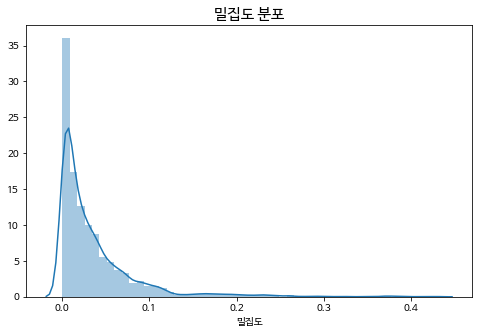

In [ ]:
# 밀집도 분포
plt.figure(figsize=(8,5))
sns.distplot(final['밀집도'])
plt.title("밀집도 분포",fontdict={'fontsize':15})

In [ ]:
final['밀집도'].describe()

count    3840.000000
mean        0.037011
std         0.049758
min         0.000191
25%         0.006693
50%         0.020300
75%         0.046742
max         0.428735
Name: 밀집도, dtype: float64

밀집도를 살펴보면 왼쪽으로 치우치고 오른쪽 꼬리가 매우 긴 분포임을 알 수 있다. 

연속값인 밀집도를 기반으로 코로나 확산 위험도를 1, 2, 3단계로 라벨링하기 위해 __K-Means Clustering__을 진행한다. 클러스터 개수를 3으로 지정 후, '밀집도'를 입력변수로 하여 전체 데이터를 3개의 그룹으로 군집화한다. 군집 결과 첫번째 클러스터의 위험도를 1, 두번째 클러스터의 위험도를 2, 세번째 클러스터의 위험도를 3으로 라벨링하여 분류 알고리즘의 예측 타겟변수 '코로나 확산 위험도'를 완성한다.  

In [ ]:
## k-means clustering
from sklearn.cluster import KMeans
features = ['밀집도']

X = final[features]
X_train = pd.get_dummies(X)

model = KMeans(n_clusters=3, random_state=0)
model.fit(X_train)
y_pred = model.labels_

final['cluster_label'] = y_pred

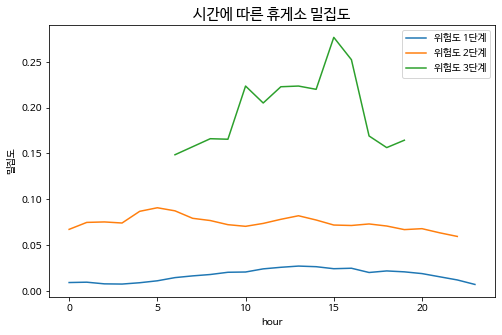

In [ ]:
# 클러스터링 결과 시각화
plt.figure(figsize=(8,5))
sns.lineplot(data=final[final['cluster_label']==0], x='hour', y='밀집도', ci=None, label='위험도 1단계')
sns.lineplot(data=final[final['cluster_label']==1], x='hour', y='밀집도', ci=None, label='위험도 2단계')
sns.lineplot(data=final[final['cluster_label']==2], x='hour', y='밀집도', ci=None, label='위험도 3단계')
plt.title("시간에 따른 휴게소 밀집도", fontdict={'fontsize':15})
plt.legend()
plt.show()

밀집도를 변수로 하여 n_clusters=3으로 클러스터링 한 결과, 위험도 1단계는 cluster1, 2단계는 cluster2, 3단계는 cluster3으로 군집화되었다고 볼 수 있다.   
위험도 1, 2단계는 전 시간대에 걸쳐 분포하는 반면. 3단계의 경우 6시에서 20시 사이에만 분포하는 것을 알 수 있다. 

In [ ]:
final['위험도'] = final['cluster_label'].apply(lambda x: 1 if x==0 else(2 if x==1 else 3)) 

In [ ]:
final[['휴게소명','datetime_15','밀집도','위험도']].head()

,휴게소명,datetime_15,밀집도,위험도
0,건천(부산),2019-02-04 00:00:00,0.008501,1
1,건천(부산),2019-02-04 00:15:00,0.010930,1
2,건천(부산),2019-02-04 00:30:00,0.010930,1
3,건천(부산),2019-02-04 00:45:00,0.010930,1
4,건천(부산),2019-02-04 01:00:00,0.013359,1


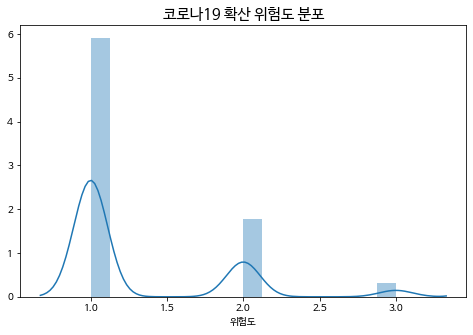

In [ ]:
# 위험도 분포
plt.figure(figsize=(8,5))
sns.distplot(final['위험도'])
plt.title("코로나19 확산 위험도 분포",fontdict={'fontsize':15})
plt.show()

In [ ]:
final['위험도'].value_counts()

1    2836
2     848
3     156
Name: 위험도, dtype: int64

휴게소의 밀집도를 코로나 확산 위험도로 라벨링한 결과, 데이터 수가 1단계 > 2단계 > 3단계 순으로 많은 매우 불균형한 자료의 형태임을 알 수 있다.

In [ ]:
print("코로나19 확산 위험도 1단계 Range: ", round(final.loc[final['위험도']==1,'밀집도'].min(),3), "~", round(final.loc[final['위험도']==1,'밀집도'].max(),3))
print("코로나19 확산 위험도 2단계 Range: ", round(final.loc[final['위험도']==2,'밀집도'].min(),3), "~", round(final.loc[final['위험도']==2,'밀집도'].max(),3))
print("코로나19 확산 위험도 3단계 Range: ", round(final.loc[final['위험도']==3,'밀집도'].min(),3), "~", round(final.loc[final['위험도']==3,'밀집도'].max(),3))

코로나19 확산 위험도 1단계 Range:  0.0 ~ 0.045
코로나19 확산 위험도 2단계 Range:  0.045 ~ 0.148
코로나19 확산 위험도 3단계 Range:  0.149 ~ 0.429


코로나19 확산 위험도의 밀집도 범위를 보면, 1단계는 약 0 ~ 0.2, 2단계는 약 0.2 ~ 0.6, 3단계는 약 0.6 ~1.7로 이루어져있음을 볼 수 있다.

#### __밀도 교통량 구하기__

<img src='https://drive.google.com/uc?export=view&id=1GO7BDokS4-A7Fz87gr92kucxWPFgs67-' width="800">



- **밀도 교통량은 도로구간에 차량이 얼마나 빽빽하게 들어서있는지를 나타내는 지표로, 15분 간격으로 밀도 교통량 값을 계산**하였다. 예를 들어 2월 4일 오후 2시 45분 A 도로구간의 밀도 교통량 값이 높다면, 2월 4일 오후 2시 31분부터 오후 2시 45분 사이 A 도로구간이 정체되었다는 의미이다.
- 밀도 교통량을 계산한 방법은 다음과 같다. 하루치 DSRC 데이터를 이용해 모든 차량의 경로를 딕셔너리로 만든 뒤, 이전 도로이정을 지나간 시각과 이후 도로이정을 지나간 시각을 토대로 도로구간에 머문 차량의 대수를 구하였다. 예를 들어, i 도로이정 다음에 j 도로이정이 나올 때, 차량 ㄱ이 i 도로이정을 지났다고 찍힌 시각이 오전 8시 6분이고 j 도로이정을 지났다고 찍힌 시각이 오전 8시 18분이라면, 차량 ㄱ은 오전 8시 15분에 반드시 i-j 도로구간을 지났다는 점에 착안하여 도로구간에 머문 차량의 대수를 계산하였다.
- **그런데 동일한 대수의 차가 있더라도 차종에 따라 밀도 교통량이 달라질 것이다**. 예를 들어 길이가 같은 a 도로구간과 b 도로구간에 동일하게 10대의 차량이 있다고 가정하자. 이때 a 도로구간에는 버스 10대가 있고 b 도로구간에는 승용차 10대가 있다면, 같은 10대이더라도 a 도로구간에서 차가 더 밀릴 가능성이 있다. 따라서 차종별로 서로 다른 계수값을 적용하여 밀도 교통량을 구했다. 
- **차종별 계수값은 차종별 장축(차의 길이)의 평균을 사용했다**. 차종별로 2개의 차량 모델을 선정하여 해당 차량의 장축의 평균을 내어 계산하였다. 차종분류기준에 차량의 장축에 대한 설명이 없기 때문에 자체적으로 실제 차량의 장축값을 계산하였고, 각 차종에 해당되는 다양한 종류의 차량이 있지만 차종별로 대표적인 2개 차량의 평균값을 사용하기로 했다. 실제 차종별로 참고한 차량모델과 차량별 장축은 다음과 같다(단위: mm).
  - 1종차량: 현대 소나타(4855), 현대 그랜저(4930)
  - 2종차량: 현대 카운티 25인승(7085), 현대 에어로타운 24+1인승(8495)
  - 3종차량: 현대 유니시티 41+1인승(10955), 현대 유니버스 45+1인승(12000) 

**차종 설명**  

<img src='https://drive.google.com/uc?export=view&id=1zm2L4zP3nTaqRioIGsyevzgUqPbpjHav' width="800">


     출처: (주)한가람물류/더 청솔물류 홈페이지 고속도로 통행료 기준표 1종~5종 (http://www.csgls.com/ab-notice_v-177?PB_1416299127=4)

In [ ]:
def create_density_df(day):

  # 해당일자의 파일 불러오기 
  df = pd.read_csv('./dsrc'+day+'_down.csv', parse_dates=['datetime','datetime_15']).drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)  # 불필요한 열(Unnamed: 0, Unnamed: 0.1) 제거 

  # 도로이정_id 변수를 생성(도로이정 변수를 문자형으로 변환한 것)
  df['도로이정_id'] = df['도로이정'].astype(str)

  # 차종에 따라 계수 계산
  # (계수값에 대한 논의 필요)
  df.loc[df['DSRC차종구분명'] == '1종', '차종계수'] =5.06 # 1종차량(소형차)일 때 차종계수는 1
  df.loc[df['DSRC차종구분명'] == '2종', '차종계수'] =8.06  # 2종차량(중형차)일 때 차종계수는 2
  df.loc[df['DSRC차종구분명'] == '3종', '차종계수'] =11.88  # 3종차량(대형차)일 때 차종계수는 3 

  # 인덱싱 다시 설정하기 
  df.reset_index(drop=True, inplace=True)

  # 경로 만드는 데 필요한 컬럼만 뽑아내어 데이터프레임 daily를 생성 
  daily = df[['가상OBU_ID', 'datetime', 'datetime_15', '도로이정_id', '차종계수']]

  # 차종별로 정렬 
  daily = daily.sort_values(by=['가상OBU_ID'], axis=0) 

  # 경로 리스트 생성하기: route_list
  route_list = daily.groupby(['가상OBU_ID', '차종계수']).apply(lambda x: dict(zip(x.도로이정_id, x.datetime_15))).reset_index(name='route').to_dict(orient='records')

  # 밀도 리스트 생성하기 
  # 빈 밀도 리스트 생성: density_list
  density_list = []

  for car_id in range(len(route_list)):

    # 도로이정_id 내림차순(하행 방향)으로 정렬 - route_list 이용 
    sorted_dic = sorted(route_list[car_id].get('route').items(), reverse=True) 

    # 정렬한 경로 딕셔너리를 list로 저장: id, 차종계수, 시간, 도로_id 순으로 값을 저장 
    sorted_dic_list = []
    for id, (doropoint, time) in enumerate(sorted_dic):
      sorted_dic_list.append([id, route_list[car_id]['차종계수'], time, doropoint])

    # 2번째 차량의 모든 경우에 대해 반복 
    for i in range(len(sorted_dic_list)-1):

      # 15분 커졌을 때
      if (sorted_dic_list[i+1][2] - sorted_dic_list[i][2] == timedelta(minutes = 15)):
        # 도로이정_id가 바뀌지 않았으면: pass 
        if sorted_dic_list[i][2] == sorted_dic_list[i+1][2]:
          pass
        # 도로이정_id가 바뀌었으면
        else:
          carid = sorted_dic_list[i][1]
          cartype = sorted_dic_list[i][1]
          start_doropoint = sorted_dic_list[i][3]
          end_doropoint = sorted_dic_list[i+1][3]
          changetime = sorted_dic_list[i+1][2]
          # density_list에 시작_도로이정id(start_doropoint), 종료_도로이정id(end_doropoint), 바뀐 시각(changetime)을 density_list에 추가 
          density_list.append([cartype, start_doropoint, end_doropoint, changetime, ])
      
      # 15분 커지지 않았을 때 
      if (sorted_dic_list[i+1][2] - sorted_dic_list[i][2] != timedelta(minutes = 15)):
        pass
  
  # density_list를 데이터프레임으로 변환
  density_df = pd.DataFrame(density_list, columns=['차종계수', '시작_도로이정', '종료_도로이정', '시간대'])

  ############  최종 결과물  ############
  # 차량 대수에 대한 밀도 교통량 데이터프레임: density_df2
  ##density_df2 = density_df.groupby(['차종계수', '시작_도로이정', '종료_도로이정', '시간대']).size().unstack('시간대', fill_value=0)

  # 차종계수를 곱한 밀도 교통량 데이터프레임: density_df3
  density_df3 = density_df.pivot_table(index=['차종계수', '시작_도로이정', '종료_도로이정'], columns='시간대', aggfunc=lambda x: np.sum(x.차종계수), fill_value=0) 

  # 차종 구분 없이 시간대별로 합한 최종 밀도 교통량 데이터프레임: density_df4
  density_df4 = density_df3.groupby(['시작_도로이정','종료_도로이정']).agg('sum')
  #######################################

  # 데이터 내보내기
  ##density_df2.to_csv('density%s_carnum.csv' % day)
  ##density_df3.to_csv('density%s.csv' % day)
  #density_df4.to_csv('density%s_final.csv' % day)
  
create_density_df('20200124')
create_density_df('20200125')
create_density_df('20190204')
create_density_df('20190205')

아래 데이터프레임은 최종적으로 만든 밀도 교통량의 중 2020년 설연휴 첫날에 해당하는 데이터이다.

In [ ]:
# 20200124 밀도교통량
density20200124_final = pd.read_csv('../data/density20200124_final.csv')
density20200124_final

,시작_도로이정,종료_도로이정,2020-01-24 00:15:00,2020-01-24 00:30:00,2020-01-24 00:45:00,2020-01-24 01:00:00,2020-01-24 01:15:00,2020-01-24 01:30:00,2020-01-24 01:45:00,2020-01-24 02:00:00,2020-01-24 02:15:00,2020-01-24 02:30:00,2020-01-24 02:45:00,2020-01-24 03:00:00,2020-01-24 03:15:00,2020-01-24 03:30:00,2020-01-24 03:45:00,2020-01-24 04:00:00,2020-01-24 04:15:00,2020-01-24 04:30:00,2020-01-24 04:45:00,2020-01-24 05:00:00,2020-01-24 05:15:00,2020-01-24 05:30:00,2020-01-24 05:45:00,2020-01-24 06:00:00,2020-01-24 06:15:00,2020-01-24 06:30:00,2020-01-24 06:45:00,2020-01-24 07:00:00,2020-01-24 07:15:00,2020-01-24 07:30:00,2020-01-24 07:45:00,2020-01-24 08:00:00,2020-01-24 08:15:00,2020-01-24 08:30:00,2020-01-24 08:45:00,2020-01-24 09:00:00,2020-01-24 09:15:00,2020-01-24 09:30:00,...,2020-01-24 14:00:00,2020-01-24 14:15:00,2020-01-24 14:30:00,2020-01-24 14:45:00,2020-01-24 15:00:00,2020-01-24 15:15:00,2020-01-24 15:30:00,2020-01-24 15:45:00,2020-01-24 16:00:00,2020-01-24 16:15:00,2020-01-24 16:30:00,2020-01-24 16:45:00,2020-01-24 17:00:00,2020-01-24 17:15:00,2020-01-24 17:30:00,2020-01-24 17:45:00,2020-01-24 18:00:00,2020-01-24 18:15:00,2020-01-24 18:30:00,2020-01-24 18:45:00,2020-01-24 19:00:00,2020-01-24 19:15:00,2020-01-24 19:30:00,2020-01-24 19:45:00,2020-01-24 20:00:00,2020-01-24 20:15:00,2020-01-24 20:30:00,2020-01-24 20:45:00,2020-01-24 21:00:00,2020-01-24 21:15:00,2020-01-24 21:30:00,2020-01-24 21:45:00,2020-01-24 22:00:00,2020-01-24 22:15:00,2020-01-24 22:30:00,2020-01-24 22:45:00,2020-01-24 23:00:00,2020-01-24 23:15:00,2020-01-24 23:30:00,2020-01-24 23:45:00
0,10.9,1.0,182.16,197.34,96.14,146.74,111.32,141.68,143.44,156.86,124.44,106.26,75.90,131.56,15.18,82.72,45.54,55.66,53.60,60.72,60.72,60.72,65.78,40.48,70.84,80.96,124.96,106.26,91.08,70.84,86.02,141.68,177.10,133.32,200.34,166.98,214.28,156.86,182.16,273.24,...,318.78,323.84,303.60,232.76,364.32,290.18,202.40,308.66,273.24,263.12,278.30,298.54,318.78,273.24,313.72,222.64,202.40,227.70,212.52,158.62,178.86,177.10,116.38,207.46,86.02,116.38,101.20,131.56,96.14,65.78,65.78,86.02,75.90,86.02,80.96,101.20,40.48,25.30,65.78,40.48
1,115.0,108.2,30.36,72.60,40.48,30.36,35.42,15.18,15.18,35.42,30.36,20.24,10.12,37.18,5.06,15.18,10.12,16.94,15.18,15.18,15.18,5.06,20.24,20.24,10.12,35.42,45.54,30.36,20.24,35.42,35.42,65.78,70.84,91.08,55.66,96.14,116.38,146.74,166.98,182.16,...,161.92,219.34,207.46,222.64,187.22,141.68,197.34,116.38,156.86,177.10,141.68,131.56,126.50,121.44,80.96,172.04,131.56,106.26,111.32,116.38,86.02,70.84,45.54,50.60,40.48,40.48,35.42,50.60,40.48,35.42,30.36,5.06,25.30,30.36,30.36,30.36,20.24,30.36,15.18,15.18
2,117.9,108.2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.06,0.00,5.06,5.06,5.06,5.06,10.12,5.06,0.00,0.00,0.00,0.00,...,0.00,5.06,5.06,10.12,10.12,0.00,0.00,10.12,10.12,0.00,0.00,5.06,10.12,0.00,0.00,5.06,0.00,5.06,0.00,10.12,5.06,10.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.06,0.00
3,117.9,115.0,50.60,15.18,30.36,40.48,10.12,10.12,15.18,5.06,10.12,10.12,5.06,15.18,15.18,10.12,15.18,10.12,15.18,5.06,25.30,10.12,10.12,10.12,10.12,5.06,10.12,30.36,15.18,35.42,50.60,20.24,40.48,55.66,60.72,65.78,65.78,80.96,124.44,70.84,...,80.96,116.38,80.96,131.56,121.44,75.90,75.90,96.14,106.26,80.96,65.78,75.90,96.14,55.66,50.60,65.78,40.48,104.20,50.60,60.72,60.72,25.30,60.72,20.24,40.48,20.24,5.06,40.48,10.12,10.12,35.42,20.24,25.30,15.18,25.30,15.18,10.12,20.24,20.24,10.12
4,121.3,108.2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,5.06,5.06,0.00,5.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# final 데이터에 밀도교통량 컬럼 추가 (6 구간)
for day in ['20190204','20190205','20200124','20200125']:
    data = pd.read_csv('density%s_final.csv' %day)
    
    for name in 휴게소명: 
        b6 = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j-6'].values[0] 
        b5 = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j-5'].values[0] 
        b4 = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j-4'].values[0] 
        b3 = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j-3'].values[0]
        b2 = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j-2'].values[0]
        b1 = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j-1'].values[0]
        a = hugeso_info_down.loc[hugeso_info_down['휴게소명']==name,'j+1'].values[0]

        # 추풍령 결측치 대체하기 (포함 구간을 이후 구간으로 대체: b ~ a의 밀도교통량을 a ~ aa의 밀도교토량으로 대체 )
        if name == '추풍령(부산)':
          a =  96.6
          aa = 90.5 

          포함구간_density = pd.DataFrame(data[(data['시작_도로이정']==a ) & (data['종료_도로이정']==aa)].stack()[2:]).reset_index().iloc[:,1:] ## b, a를 a, aa로 대체 
          포함구간_density['휴게소명'] = name
          포함구간_density.columns=['datetime_15','포함구간_밀도교통량','휴게소명']
          포함구간_density['포함구간_밀도교통량'] = 포함구간_density['포함구간_밀도교통량']/(a-aa)
          포함구간_density['datetime_15'] = pd.to_datetime(포함구간_density['datetime_15']) 

        else:
          포함구간_density = pd.DataFrame(data[(data['시작_도로이정']==b1) & (data['종료_도로이정']==a)].stack()[2:]).reset_index().iloc[:,1:]
          포함구간_density['휴게소명'] = name
          포함구간_density.columns=['datetime_15','포함구간_밀도교통량','휴게소명']
          포함구간_density['포함구간_밀도교통량'] = 포함구간_density['포함구간_밀도교통량']/(b1-a)
          포함구간_density['datetime_15'] = pd.to_datetime(포함구간_density['datetime_15'])

    
        for i in range(len(포함구간_density)):
            indx = (final['datetime_15']==포함구간_density.loc[i,'datetime_15']) & (final['휴게소명']==포함구간_density.loc[i,'휴게소명'])
            final.loc[indx,'포함구간_밀도교통량'] = 포함구간_density.loc[i,'포함구간_밀도교통량']


        전1구간_density = pd.DataFrame(data[(data['시작_도로이정']==b2) & (data['종료_도로이정']==b1)].stack()[2:]).reset_index().iloc[:,1:]
        전1구간_density['휴게소명'] = name
        전1구간_density.columns=['datetime_15','전1구간_밀도교통량','휴게소명']
        전1구간_density['전1구간_밀도교통량'] = 전1구간_density['전1구간_밀도교통량']/(b2-b1)
        전1구간_density['datetime_15'] = pd.to_datetime(전1구간_density['datetime_15'])
        
        for i in range(len(전1구간_density)):
            indx = (final['datetime_15']==전1구간_density.loc[i,'datetime_15']) & (final['휴게소명']==전1구간_density.loc[i,'휴게소명'])
            final.loc[indx,'전1구간_밀도교통량'] = 전1구간_density.loc[i,'전1구간_밀도교통량']


        전2구간_density = pd.DataFrame(data[(data['시작_도로이정']==b3) & (data['종료_도로이정']==b2)].stack()[2:]).reset_index().iloc[:,1:]
        전2구간_density['휴게소명'] = name
        전2구간_density.columns=['datetime_15','전2구간_밀도교통량','휴게소명']
        전2구간_density['전2구간_밀도교통량'] = 전2구간_density['전2구간_밀도교통량']/(b3-b2)
        전2구간_density['datetime_15'] = pd.to_datetime(전2구간_density['datetime_15'])
        
        for i in range(len(전2구간_density)):
            indx = (final['datetime_15']==전2구간_density.loc[i,'datetime_15']) & (final['휴게소명']==전2구간_density.loc[i,'휴게소명'])
            final.loc[indx,'전2구간_밀도교통량'] = 전2구간_density.loc[i,'전2구간_밀도교통량']

            
        전3구간_density = pd.DataFrame(data[(data['시작_도로이정']==b4) & (data['종료_도로이정']==b3)].stack()[2:]).reset_index().iloc[:,1:]
        전3구간_density['휴게소명'] = name
        전3구간_density.columns=['datetime_15','전3구간_밀도교통량','휴게소명']
        전3구간_density['전3구간_밀도교통량'] = 전3구간_density['전3구간_밀도교통량']/(b4-b3)
        전3구간_density['datetime_15'] = pd.to_datetime(전3구간_density['datetime_15'])
        
        for i in range(len(전3구간_density)):
            indx = (final['datetime_15']==전3구간_density.loc[i,'datetime_15']) & (final['휴게소명']==전3구간_density.loc[i,'휴게소명'])
            final.loc[indx,'전3구간_밀도교통량'] = 전3구간_density.loc[i,'전3구간_밀도교통량']

        전4구간_density = pd.DataFrame(data[(data['시작_도로이정']==b5) & (data['종료_도로이정']==b4)].stack()[2:]).reset_index().iloc[:,1:]
        전4구간_density['휴게소명'] = name
        전4구간_density.columns=['datetime_15','전4구간_밀도교통량','휴게소명']
        전4구간_density['전4구간_밀도교통량'] = 전4구간_density['전4구간_밀도교통량']/(b5-b4)
        전4구간_density['datetime_15'] = pd.to_datetime(전4구간_density['datetime_15'])
        
        for i in range(len(전4구간_density)):
            indx = (final['datetime_15']==전4구간_density.loc[i,'datetime_15']) & (final['휴게소명']==전4구간_density.loc[i,'휴게소명'])
            final.loc[indx,'전4구간_밀도교통량'] = 전4구간_density.loc[i,'전4구간_밀도교통량']

        전5구간_density = pd.DataFrame(data[(data['시작_도로이정']==b6) & (data['종료_도로이정']==b5)].stack()[2:]).reset_index().iloc[:,1:]
        전5구간_density['휴게소명'] = name
        전5구간_density.columns=['datetime_15','전5구간_밀도교통량','휴게소명']
        전5구간_density['전5구간_밀도교통량'] = 전5구간_density['전5구간_밀도교통량']/(b6-b5)
        전5구간_density['datetime_15'] = pd.to_datetime(전5구간_density['datetime_15'])
        
        for i in range(len(전5구간_density)):
            indx = (final['datetime_15']==전5구간_density.loc[i,'datetime_15']) & (final['휴게소명']==전5구간_density.loc[i,'휴게소명'])
            final.loc[indx,'전5구간_밀도교통량'] = 전5구간_density.loc[i,'전5구간_밀도교통량']



# 밀도교통량 결측치 채우기 (보간법)
final.index = final['datetime_15'] ; final.index.name=None # datetime 인덱스로 바꾸기
for month in range(2):
    for name in 휴게소명:
        indx = (final['datetime_15'].dt.month==month+1) & (final['휴게소명']==name)
        final.loc[indx,'포함구간_밀도교통량'] = final.loc[indx,'포함구간_밀도교통량'].interpolate(method='time')
        final.loc[indx,'전1구간_밀도교통량'] = final.loc[indx,'전1구간_밀도교통량'].interpolate(method='time')
        final.loc[indx,'전2구간_밀도교통량'] = final.loc[indx,'전2구간_밀도교통량'].interpolate(method='time')
        final.loc[indx,'전3구간_밀도교통량'] = final.loc[indx,'전3구간_밀도교통량'].interpolate(method='time')
        final.loc[indx,'전4구간_밀도교통량'] = final.loc[indx,'전4구간_밀도교통량'].interpolate(method='time')
        final.loc[indx,'전5구간_밀도교통량'] = final.loc[indx,'전5구간_밀도교통량'].interpolate(method='time')
        

# 연휴 첫날 00시 00분 데이터를 00시 15분 데이터로 대체 
final.포함구간_밀도교통량 = final.groupby(['휴게소명']).포함구간_밀도교통량.fillna(method='bfill', limit=1)
final.전1구간_밀도교통량 = final.groupby(['휴게소명']).전1구간_밀도교통량.fillna(method='bfill', limit=1)
final.전2구간_밀도교통량 = final.groupby(['휴게소명']).전2구간_밀도교통량.fillna(method='bfill', limit=1)
final.전3구간_밀도교통량 = final.groupby(['휴게소명']).전3구간_밀도교통량.fillna(method='bfill', limit=1)
final.전4구간_밀도교통량 = final.groupby(['휴게소명']).전4구간_밀도교통량.fillna(method='bfill', limit=1)
final.전5구간_밀도교통량 = final.groupby(['휴게소명']).전5구간_밀도교통량.fillna(method='bfill', limit=1)

과거값 & 미래값 변수 생성

In [ ]:
# 과거값 & 미래값 변수 생성
datetime_list = [date(2019,2,4),date(2019,2,5),date(2020,1,24),date(2020,1,25)]
for i in range(len(datetime_list)):
    indx = (final['datetime_15'].dt.date == datetime_list[i])
    final.loc[indx,'15분 후 밀집도'] = final[indx].groupby('휴게소명').shift(-1)['밀집도']
    final.loc[indx,'15분 후 위험도'] = final[indx].groupby('휴게소명').shift(-1)['위험도']
    final.loc[indx,'15분 전 교통량(대)'] = final[indx].groupby('휴게소명').shift(-1)['교통량(대)']
    final.loc[indx,'15분 전 교통량/구간길이(km)'] = final[indx].groupby('휴게소명').shift(-1)['교통량/구간길이(km)']
    final.loc[indx,'15분 전 평균속도(km/h)'] = final[indx].groupby('휴게소명').shift(-1)['평균속도(km/h)']
    final.loc[indx,'15분 전 교통사고발생'] = final[indx].groupby('휴게소명').shift(-1)['교통사고발생']
    final.loc[indx,'15분 전 포함구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-1)['포함구간_밀도교통량']
    final.loc[indx,'15분 전 전1구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-1)['전1구간_밀도교통량']
    final.loc[indx,'15분 전 전2구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-1)['전2구간_밀도교통량']
    final.loc[indx,'15분 전 전3구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-1)['전3구간_밀도교통량']
    final.loc[indx,'15분 전 전4구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-1)['전4구간_밀도교통량']
    #final.loc[indx,'15분 전 전5구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-1)['전5구간_밀도교통량']
    
    final.loc[indx,'30분 후 밀집도'] = final[indx].groupby('휴게소명').shift(-2)['밀집도']
    final.loc[indx,'30분 후 위험도'] = final[indx].groupby('휴게소명').shift(-2)['위험도']
    final.loc[indx,'30분 전 교통량(대)'] = final[indx].groupby('휴게소명').shift(-2)['교통량(대)']
    final.loc[indx,'30분 전 교통량/구간길이(km)'] = final[indx].groupby('휴게소명').shift(-2)['교통량/구간길이(km)']
    final.loc[indx,'30분 전 평균속도(km/h)'] = final[indx].groupby('휴게소명').shift(-2)['평균속도(km/h)']
    final.loc[indx,'30분 전 교통사고발생'] = final[indx].groupby('휴게소명').shift(-2)['교통사고발생']
    final.loc[indx,'30분 전 포함구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-2)['포함구간_밀도교통량']
    final.loc[indx,'30분 전 전1구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-2)['전1구간_밀도교통량']
    final.loc[indx,'30분 전 전2구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-2)['전2구간_밀도교통량']
    final.loc[indx,'30분 전 전3구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-2)['전3구간_밀도교통량']
    final.loc[indx,'30분 전 전4구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-2)['전4구간_밀도교통량']
    #final.loc[indx,'30분 전 전5구간_밀도교통량'] = final[indx].groupby('휴게소명').shift(-2)['전5구간_밀도교통량']

In [ ]:
# 불필요한 컬럼 삭제 
final.drop(['위도','경도','주유소유무','버스환승가능여부','도로이정(추정치)','화장실유무','약국유무','수유실유무','매점유무','음식점유무','j-6', 'j-5', 'j-4', 'j-3', 'j-2', 'j-1', 'j+1', 'j+2',
        '이용인원','주차면수', '주차장면적', '건물면적','cluster_label'], axis=1, inplace=True)

최종 분석 데이터셋: final

In [ ]:
final.head()

,휴게소명,휴게소종류,도로점용면적,경정비가능여부,LPG충전소유무,전기차충전소유무,쉼터유무,직전휴게소와의 거리,datetime_15,휴게소주차장_합계,...,30분 후 위험도,30분 전 교통량(대),30분 전 교통량/구간길이(km),30분 전 평균속도(km/h),30분 전 교통사고발생,30분 전 포함구간_밀도교통량,30분 전 전1구간_밀도교통량,30분 전 전2구간_밀도교통량,30분 전 전3구간_밀도교통량,30분 전 전4구간_밀도교통량
2019-02-04 00:00:00,건천(부산),간이휴게소,13041,0,0,1,1,22.67868,2019-02-04 00:00:00,146.0,...,1.0,276.0,26.538462,117.4,0.0,11.905882,1.1,0.887719,1.659016,NaN
2019-02-04 00:15:00,건천(부산),간이휴게소,13041,0,0,1,1,22.67868,2019-02-04 00:15:00,146.0,...,1.0,276.0,26.538462,117.4,0.0,13.890196,2.2,2.663158,0.000000,NaN
2019-02-04 00:30:00,건천(부산),간이휴게소,13041,0,0,1,1,22.67868,2019-02-04 00:30:00,146.0,...,1.0,220.0,21.153846,113.3,0.0,6.945098,1.1,1.775439,1.659016,NaN
2019-02-04 00:45:00,건천(부산),간이휴게소,13041,0,0,1,1,22.67868,2019-02-04 00:45:00,146.0,...,1.0,220.0,21.153846,113.3,0.0,10.913725,1.1,1.775439,4.147541,NaN
2019-02-04 01:00:00,건천(부산),간이휴게소,13041,0,0,1,1,22.67868,2019-02-04 01:00:00,146.0,...,1.0,220.0,21.153846,113.3,0.0,10.913725,0.0,3.550877,4.436066,NaN


In [ ]:
final.to_csv('final.csv')

### __2-2. EDA 시각화__

In [ ]:
final = pd.read_csv('final.csv', parse_dates=['datetime_15'])
final.drop(['Unnamed: 0'], axis=1, inplace=True)

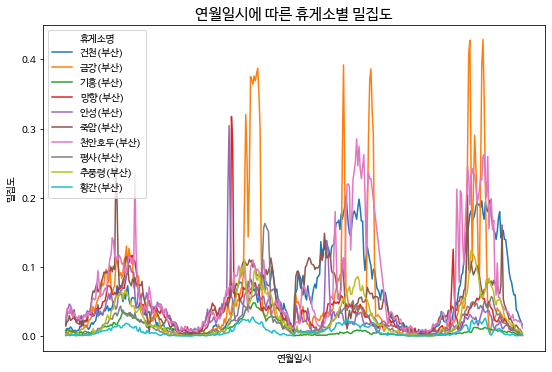

In [ ]:
#휴게소별 연월일시에 따른 밀집도
final['연월일시'] = final['datetime_15'].astype(str)

plt.figure(figsize=(9,6))
plt.xticks(rotation=-45)
df=final.loc[:,['연월일시','휴게소명','밀집도']]
sns.lineplot(data=df, x='연월일시',y='밀집도', hue='휴게소명', ci=None)

plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

plt.title('연월일시에 따른 휴게소별 밀집도', fontdict={'fontsize':15})
plt.show()

* 본 분석에서는 2019년 설날 전날과 당일, 2020년 설날 전날과 당일 총 4일의 데이터를 활용하였다.  
* 각 일자별로 밀집도가 봉우리 형태를 띄는 것을 확인할 수 있었다.  
* 또한 2019년과 2020년을 통틀어 금강휴게소의 밀집도가 압도적으로 높고, 그 다음으로 천안호두 휴게소의 밀집도가 높은 것을 확인할 수 있다.

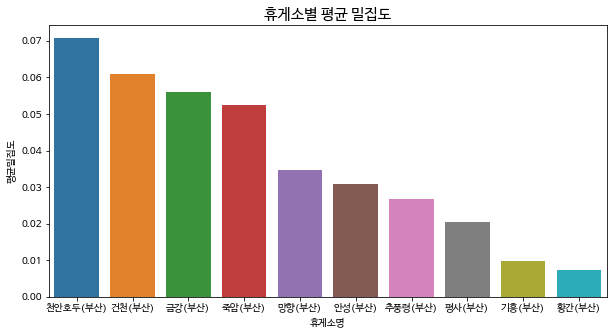

In [ ]:
plt.figure(figsize=(10,5))
df=final.sort_values(by='평균밀집도', ascending=False)
sns.barplot(data=df, x='휴게소명',y='평균밀집도')
plt.title("휴게소별 평균 밀집도", fontdict={'fontsize':15})
plt.show()

평균 밀집도는 천안호두 휴게소가 가장 높고, 건천, 금강, 죽암, 망향, ... 순으로 높다.

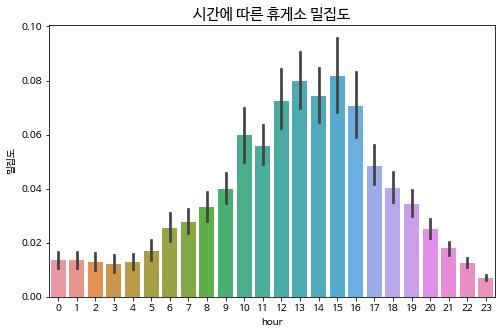

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=final, x='hour',y='밀집도')
plt.title("시간에 따른 휴게소 밀집도", fontdict={'fontsize':15})
plt.show()

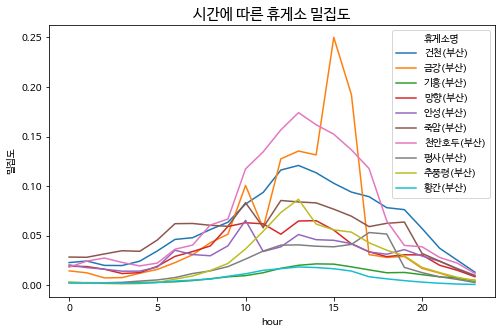

In [ ]:
plt.figure(figsize=(8,5))
sns.lineplot(data=final, x='hour', y='밀집도', hue='휴게소명', ci=None)
plt.title("시간에 따른 휴게소 밀집도", fontdict={'fontsize':15})
plt.show()

전체적인 밀집도는 10시에서 17시 사이에 가장 높은 것을 확인할 수 있다.

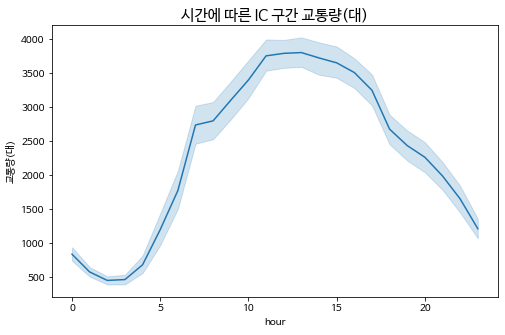

In [ ]:
plt.figure(figsize=(8,5))
sns.lineplot(data=final, x='hour', y='교통량(대)')
plt.title("시간에 따른 IC 구간 교통량(대)", fontdict={'fontsize':15})
plt.show()

전체적인 교통량 또한 휴게소 밀집도와 비슷하게 10시 ~ 16시 사이에 가장 높다.

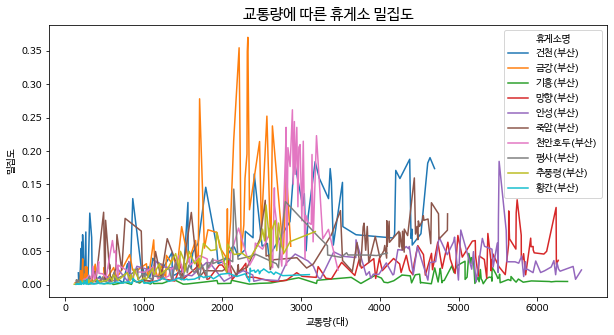

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=final, x='교통량(대)',y='밀집도', hue='휴게소명', ci=None)
plt.title("교통량에 따른 휴게소 밀집도", fontdict={'fontsize':15})
plt.show()

교통량에 따른 밀집도를 휴게소별로 시각화해보면, 동일 휴게소에 대해서 교통량이 높은 경우 밀집도또한 대체적으로 높게 나타나는 경향을 확인할 수 있다. 

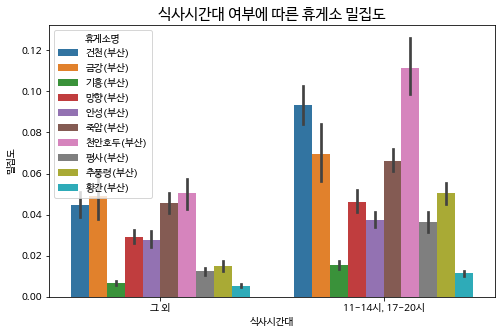

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=final, x='식사시간대',y='밀집도', hue='휴게소명')
plt.title("식사시간대 여부에 따른 휴게소 밀집도", fontdict={'fontsize':15})
plt.xticks([0,1],['그 외','11-14시, 17-20시'])
plt.show()

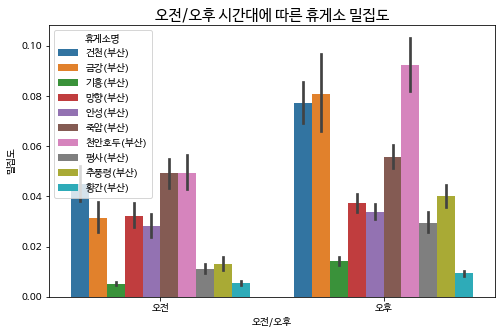

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=final, x='오전/오후',y='밀집도', hue='휴게소명')
plt.title("오전/오후 시간대에 따른 휴게소 밀집도", fontdict={'fontsize':15})
plt.xticks([0,1],['오전','오후'])
plt.show()

대부분의 휴게소에서 식사 시간대와 오후 시간대에 밀집도가 더 높음을 알 수 있다.


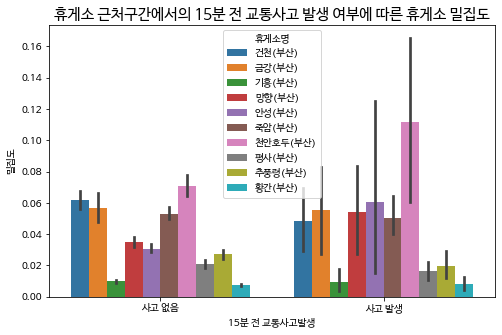

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=final, x='15분 전 교통사고발생', y='밀집도', hue='휴게소명')
plt.title("휴게소 근처구간에서의 15분 전 교통사고 발생 여부에 따른 휴게소 밀집도", fontdict={'fontsize':15})
plt.xticks([0,1],['사고 없음','사고 발생'])
plt.show()

몇몇 휴게소의 경우, 휴게소 근처에서 15분 전 교통사고가 발생한 경우 밀집도가 더욱 높게 나타난다.

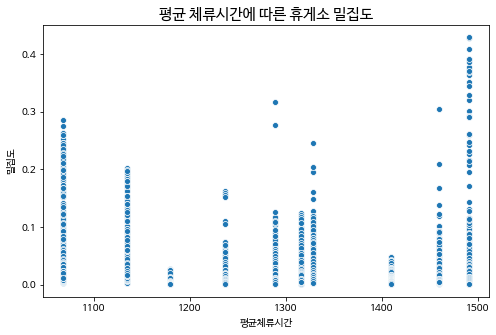

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=final, x='평균체류시간',y='밀집도')
plt.title("평균 체류시간에 따른 휴게소 밀집도", fontdict={'fontsize':15})
plt.show()

평균쳬류시간과 밀집도는 큰 상관관계는 없는 듯 하나, 체류시간이 높은 경우 밀집도도 매우 높게 나타나는 것을 확인할 수 있다. 

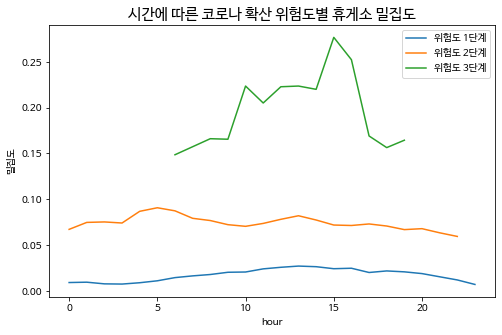

In [ ]:
plt.figure(figsize=(8,5))

sns.lineplot(data=final[final['위험도']==1], x='hour',y='밀집도',ci=None, label='위험도 1단계')
sns.lineplot(data=final[final['위험도']==2], x='hour',y='밀집도',ci=None, label='위험도 2단계')
sns.lineplot(data=final[final['위험도']==3], x='hour',y='밀집도',ci=None, label='위험도 3단계')

plt.title("시간에 따른 코로나 확산 위험도별 휴게소 밀집도", fontdict={'fontsize':15})
plt.show()

타겟변수이 위험도별로 시간에 따른 밀집도를 시각화해보면, 위험도 3단계는 6시에서 20시 사이에만 분포함을 확인할 수 있다. 

### __2-3. 휴게소 밀집도 예측 모델링__
* 분류 알고리즘으로 랜덤포레스트, SVM, LightGBM, XGBoost 사용

In [ ]:
# 모델링에 필요한 라이브러리

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score, accuracy_score, average_precision_score # Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report

# 모델 저장 라이브러리
from sklearn import datasets
import pickle
import joblib

In [ ]:
# 모델링을 위한 데이터프레임
final = pd.read_csv('final.csv', parse_dates=['datetime_15'])
final.drop(['Unnamed: 0'], axis=1, inplace=True)

# 15분 후 위험도 결측치 처리
for i in range(len(final)):
  if final.isnull().loc[i, '15분 후 위험도'] == True:
    final.loc[(final['datetime_15'] == final.loc[i, 'datetime_15'] + timedelta(minutes = 15)) & (final['휴게소명'] == final.loc[i, '휴게소명']),  '위험도']

# dtype 변경
final['상대적 위치'] = final['상대적 위치'].astype('float')
final['도로점용면적'] = final['도로점용면적'].astype('float')

df1 = final.drop(['datetime_15','밀집도','위험도', '30분 후 위험도','15분 후 밀집도','30분 후 밀집도'], axis=1).dropna()
df2 = final.drop(['datetime_15','밀집도','위험도', '30분 후 위험도','15분 후 밀집도','30분 후 밀집도'], axis=1).dropna(subset=['15분 후 위험도'])

In [ ]:
# 사용할 입력변수
features = df1.columns

X = df1[features].drop('15분 후 위험도', axis=1)
y = df1['15분 후 위험도']

# 연속형 변수 처리
numeric_features = X.select_dtypes("float").columns.to_list()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 처리
categorical_features = X.select_dtypes("object").columns.to_list()
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 훈련세트/테스트세트 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2020)

랜덤포레스트로 변수 중요도 확인

테스트 정확도: 0.932


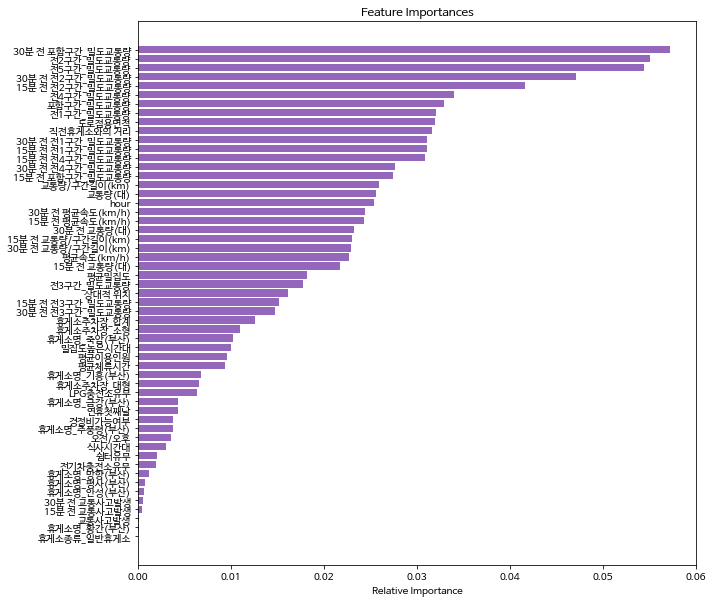

In [ ]:
## randomForest Variable Importance
from sklearn.ensemble import RandomForestClassifier

# random forest pipeline
pipe_rf = make_pipeline(preprocessor,RandomForestClassifier(random_state=2020)) 
pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
print('테스트 정확도: %.3f' % pipe_rf.score(X_test, y_test))

#variable importance
rf = RandomForestClassifier(random_state=2020)
rf.fit(pd.get_dummies(X_train), y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='tab:purple', align='center')
plt.yticks(range(len(indices)), [pd.get_dummies(X_train).columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

변수 중요도를 시각화해본 결과, 휴게소 근처 구간의 교통량이 중요한 변수임을 알 수 있다. 다음으로는 도로점용면적, 직전 휴게소와의 거리, 시간대(hour) 등이 중요한 변수로 드러났다. 한편, 휴게소명, 휴게소 종류와 같은 휴게소의 일반적 특성을 나타내는 변수는 밀집도를 분류하는데 있어 큰 역할을 하지 못했다. 

In [ ]:
## SVM 
from sklearn.svm import SVC

# svm pipeline
pipe_svm = make_pipeline(preprocessor,SVC())

# 파라미터 목록
param_grid = [{'svc__C': [1,5,10,50,100],
               'svc__gamma': [0.001,0.01,0.1,1],
               'svc__kernel': ['rbf']}]

# 다양한 측도를 사용 
scorers = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1_macro': make_scorer(f1_score, average = 'macro'),
           'f1_weighted': make_scorer(f1_score, average = 'weighted')}

# 그리드서치
gs_svm = GridSearchCV(estimator=pipe_svm,
                  param_grid=param_grid,
                  scoring=scorers,
                  refit='f1_weighted',
                  cv=5,
                  n_jobs=-1)

gs_svm.fit(X_train, y_train)

print("최적의 매개변수 조합: %s" %gs_svm.best_params_)
print("CV 정확도: %.3f" %gs_svm.best_score_)

clf_svm = gs_svm.best_estimator_
print("테스트 정확도: %.3f" % clf_svm.score(X_test, y_test))

최적의 매개변수 조합: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
CV 정확도: 0.925
테스트 정확도: 0.921


In [ ]:
# 결과:
print(classification_report(y_test, clf_svm.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       714
         2.0       0.82      0.76      0.79       174
         3.0       0.71      0.67      0.69        15

    accuracy                           0.92       903
   macro avg       0.83      0.80      0.81       903
weighted avg       0.92      0.92      0.92       903



In [ ]:
# 모델 저장하기
joblib.dump(clf_svm, './clf_svm.pkl')

['./clf_svm.pkl']

서포트 벡터 머신(SVM) 모델의 성능을 살펴보면, 1이라고 예측한 데이터의 95%가 실제로 1이었고 2라고 예측한 데이터의 82%가 실제로 2였으며, 3이라고 예측한 데이터의 71%가 실제로 3이었다. 또한 실제 1인 데이터 중의 97%가 1로 판별되었고 2인 데이터 중 76%가 2로 판별되었으며 3인 데이터 중 67%가 3으로 판별되었다.

모델의 정확도는 92%이고, 단순평균한 precision / recall / f1-score 값은 각각 0.83, 0.80, 0.81이다. 가중평균한 precision / recall / f1-score 값은 모두 0.92로 단순평균한 값들보다 높게 나왔다. 이는 표본의 갯수가 많은 클래스 1에 대해서 모델이 정확하게 예측했기 때문인 것으로 보인다.

In [ ]:
# 범주형 변수 인코딩
labelencoder = LabelEncoder()
df2['휴게소종류'] = labelencoder.fit_transform(df2['휴게소종류']) # 간이휴게소(0), 일반휴게소(1)로 변환 

cat_features = ['휴게소명', '휴게소종류','경정비가능여부','LPG충전소유무','전기차충전소유무', '쉼터유무', 
                '오전/오후', '식사시간대', '밀집도높은시간대', '연휴첫째날', '교통사고발생'] 
for col in cat_features:  
  df2[col] = df2[col].astype('category') 

# 데이터셋을 X변수와 y변수로 나눈 뒤, train과 test로 분리하는 함수 split을 정의하기  
def split(df):
  df_y = df2["15분 후 위험도"]
  df_x = df2.drop(["15분 후 위험도"], axis=1, inplace=False) 

  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.3, stratify=df_y, random_state = 2020)

  return X_train, X_test, y_train, y_test 

# 함수 split을 데이터에 적용하기 
X_train, X_test, y_train, y_test = split(df2)

In [ ]:
# NEW
## XGBClassifier
from xgboost import XGBClassifier

# XGBClassifier pipeline
pipe_xgb = make_pipeline(preprocessor,XGBClassifier())

# 파라미터 목록
learning_rate = [0.1, 0.15, 0.2]
num_iterations = [10000]
max_depth = [3, 4, 5]
min_child_weight = [1, 5, 10]
gamma = [0.5, 1, 5]

param_grid = [{'xgbclassifier__objective':['multi:softmax'],
               'xgbclassifier__max_depth': max_depth,
               'xgbclassifier__learning_rate': learning_rate,
               'xgbclassifier__num_iterations': num_iterations,
               'xgbclassifier__min_child_weight': min_child_weight,
               'xgbclassifier__gamma': gamma}]

# 그리드서치
gs_xgb = GridSearchCV(estimator=pipe_xgb,
                  param_grid=param_grid,
                  scoring='f1_micro',
                  cv=5)

gs_xgb.fit(X_train, y_train)

print("최적의 매개변수 조합: %s" %gs_xgb.best_params_)
print("CV 정확도: %.3f" %gs_xgb.best_score_)

clf_xgb = gs_xgb.best_estimator_
print("테스트 정확도: %.3f" % clf_xgb.score(X_test, y_test))

최적의 매개변수 조합: {'xgbclassifier__gamma': 1, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__num_iterations': 10000, 'xgbclassifier__objective': 'multi:softmax'}
CV 정확도: 0.927
테스트 정확도: 0.927


In [ ]:
# Result:
print(classification_report(y_test, clf_xgb.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       839
         2.0       0.85      0.85      0.85       254
         3.0       0.86      0.66      0.75        47

    accuracy                           0.93      1140
   macro avg       0.89      0.83      0.85      1140
weighted avg       0.93      0.93      0.93      1140



In [ ]:
# 모델 저장하기
joblib.dump(clf_xgb, './clf_xgb.pkl')

['./clf_xgb.pkl']

XGBoost 모델의 성능을 살펴보면, 1이라고 예측한 데이터의 95%가 실제로 1이었고 2라고 예측한 데이터의 84%가 실제로 2였으며, 3이라고 예측한 데이터의 86%가 실제로 3이었다. 또한 실제 1인 데이터 중의 95%가 1로 판별되었고 2인 데이터 중 83%가 2로 판별되었으며 3인 데이터 중 68%가 3으로 판별되었다.

모델의 정확도는 92%이고, 단순평균한 precision / recall / f1-score 값은 각각 0.89, 0.83, 0.85이다. 가중평균한 precision / recall / f1-score 값은 모두 0.92로 단순평균한 값들보다 높게 나왔다. 이는 표본의 갯수가 많은 클래스 1에 대해서 모델이 정확하게 예측했기 때문인 것으로 보인다.

In [ ]:
## LightGBM
import lightgbm as lgb

# 파라미터 값 설정 
params = {'learning_rate': 0.05,
          'max_depth': 10,
          'num_iterations': 1000,  
          'boosting_type': 'gbdt',

          'sub_feature': 0.5, 
          'num_leaves': 10,
          'min_data': 50,
          'min_child_samples': 20,
          'subsample': 0.8
          } 

# 그리드서칭 시행할 하이퍼파라미터
gridParams = {'max_depth' : [3, 5, 7], # 나무 깊이
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # 훈련량 
    'num_iterations': [1000], # 반복량
    'min_child_weight' : [5, 10, 20]}

# 다양한 측도를 사용 
scorers = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1_macro': make_scorer(f1_score, average = 'macro'),
           'f1_weighted': make_scorer(f1_score, average = 'weighted')}

# 모델 만들기 
lgb_model_GS = lgb.LGBMClassifier(boosting_type= 'gbdt', objective='multiclass', metric='multi_logloss', num_class=3, categorical_feature=cat_features,
                               learning_rate = params['learning_rate'], max_depth = params['max_depth'], num_iterations = params['num_iterations'], 
                               num_leaves = params['num_leaves'], 
                               min_data = params['min_data'], min_child_samples = params['min_child_samples'], subsample=params['subsample'],
                               n_jobs = 6, random_state =2020)  

# 그리드 만들기 
grid = GridSearchCV(lgb_model_GS, gridParams, scoring=scorers, refit='f1_weighted', return_train_score=True,
                    verbose=0, cv=2, n_jobs=2)
# 그리드 실행 
grid.fit(X_train, y_train) 

# GridSearchCV 결과를 추출해 데이터 프레임으로 반환
scores_df = pd.DataFrame(grid.cv_results_)

# 최적의 하이퍼파라미터로 업데이트 
params['learning_rate'] = grid.best_params_['learning_rate']
params['max_depth'] = grid.best_params_['max_depth']
params['min_child_weight'] = grid.best_params_['min_child_weight']
params['num_iterations'] = grid.best_params_['num_iterations']

# GridSearchCV의 refit으로 학습된 estimator 반환
estimator_best = grid.best_estimator_

# 구축한 모델로 검증데이터 예측 
y_pred_best = lgb_model_GS.fit(X_train, y_train, categorical_feature='auto') 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
# 결과:
from sklearn.metrics import precision_score, recall_score, classification_report
print(classification_report(y_test, lgb_model_GS.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.96      0.97      0.96       839
         2.0       0.85      0.84      0.85       254
         3.0       0.84      0.66      0.74        47

    accuracy                           0.93      1140
   macro avg       0.88      0.82      0.85      1140
weighted avg       0.93      0.93      0.93      1140



위 classification_report 결과에서 1이라고 예측한 데이터의 96%가 실제로 1이었고 2라고 예측한 데이터의 85%가 실제로 2였으며, 3이라고 예측한 데이터의 84%가 실제로 3이었음을 알 수 있다. 또한 실제 1인 데이터 중의 97%가 1로 판별되었고 2인 데이터 중 84%가 2로 판별되었으며 3인 데이터 중 66%가 3으로 판별되었음을 알 수 있다.

정확도는 93%이고, 단순평균한 precision / recall / f1-score 값은 각각 0.88, 0.82, 0.85이다. 가중평균한 precision / recall / f1-score 값은 모두 0.93으로 단순평균한 값들보다 높게 나왔다. 이는 표본의 갯수가 많은 클래스 1에 대해서 모델이 정확하게 예측했기 때문인 것으로 보인다.

In [ ]:
# 중첩교차검증
scores_lgb = cross_val_score(lgb_model_GS, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores_lgb),np.std(scores_lgb)))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


CV 정확도: 0.934 +/- 0.004


In [ ]:
# 모델 저장하기
from sklearn import datasets
import pickle
import joblib

joblib.dump(lgb_model_GS, './clf_lgb.pkl')

['./clf_lgb.pkl']

#### LightGBM을 통해 변수 중요도 확인 (gain 기반)


The list of features with 0 importance: 
['15분 전 교통사고발생', '교통사고발생', '전기차충전소유무']
The list of features with 0 importance: 
['15분 전 교통사고발생', '교통사고발생', '전기차충전소유무']


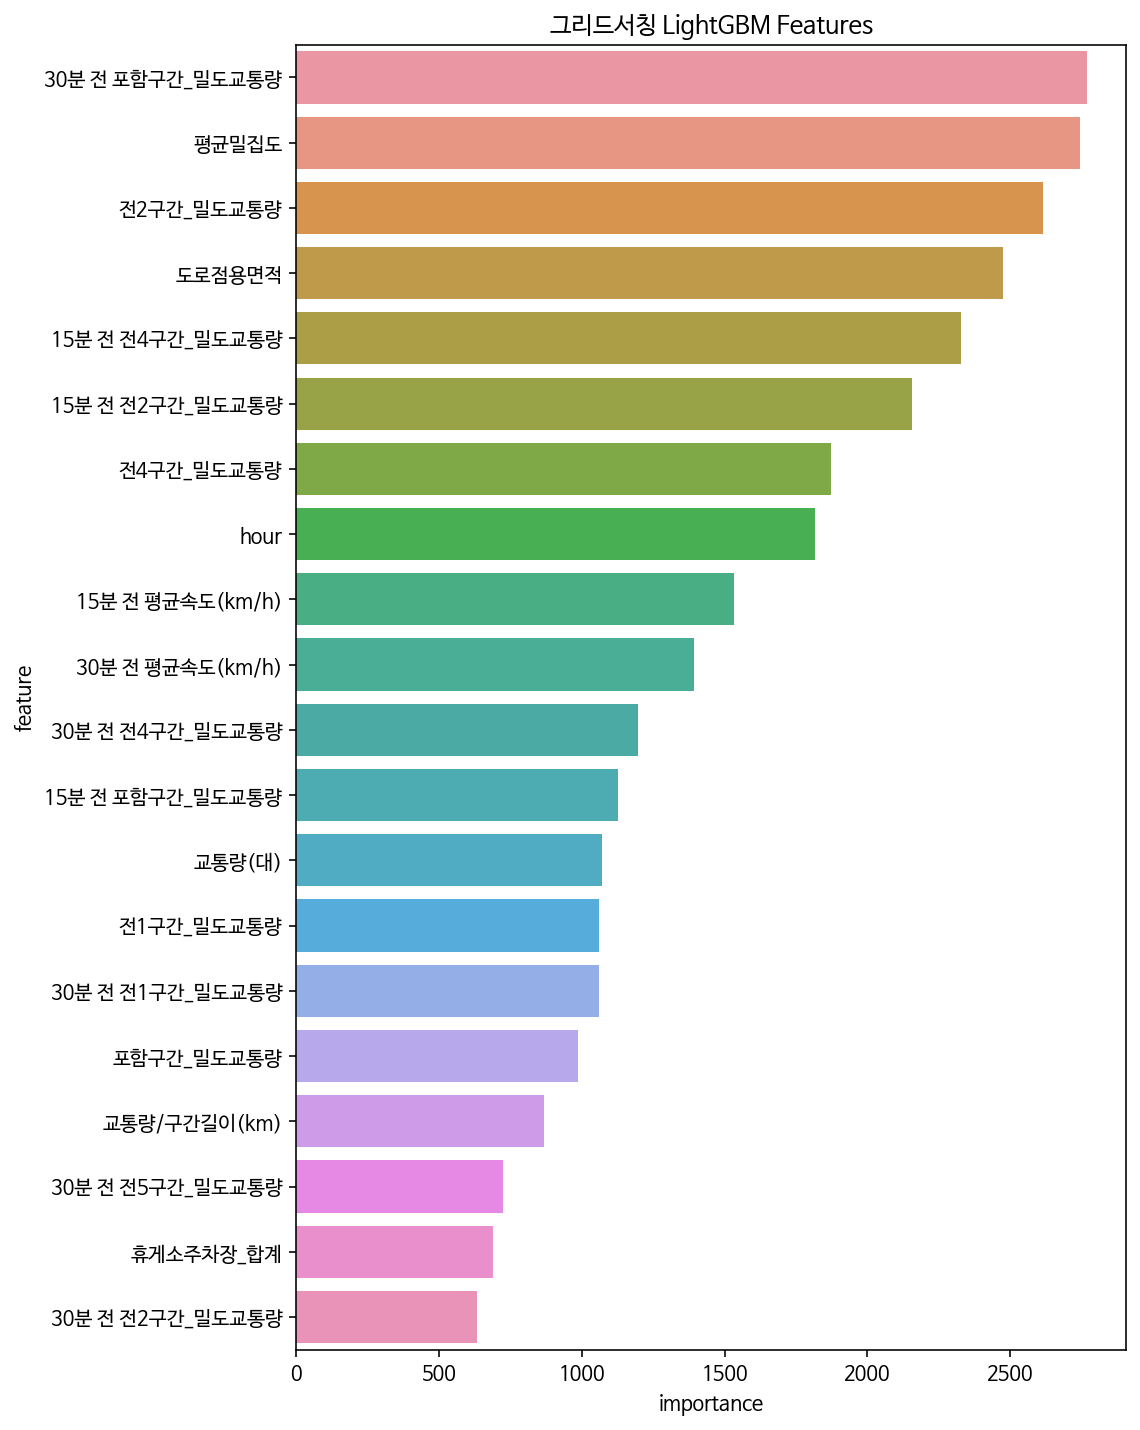

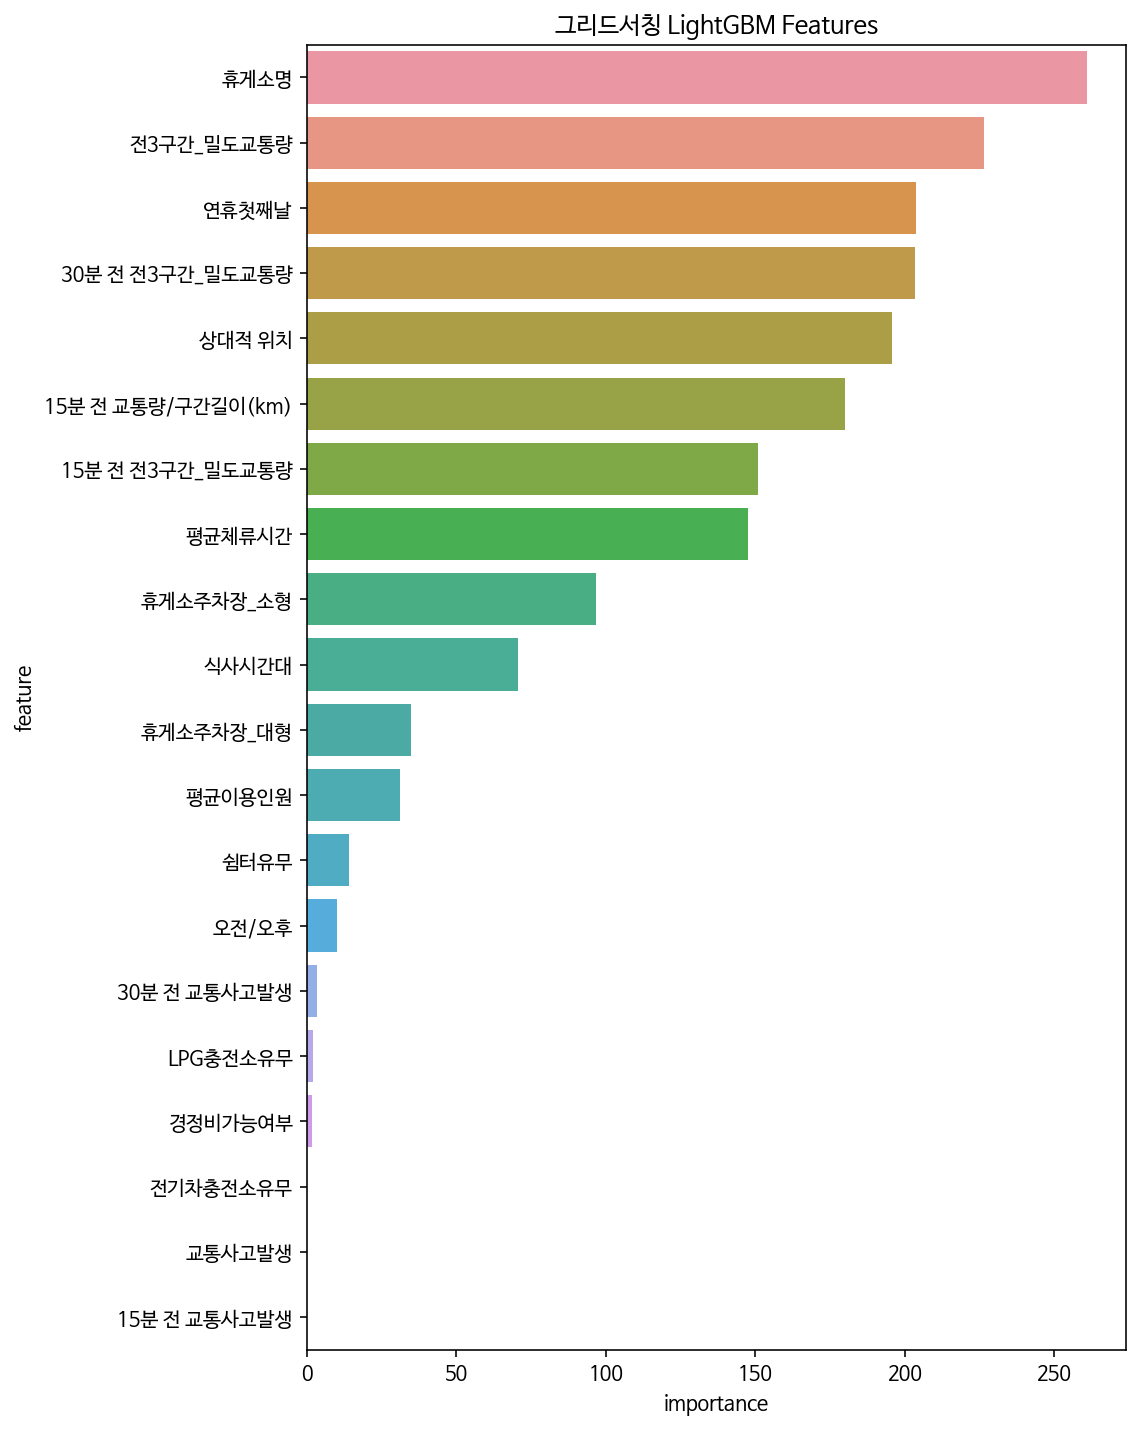

In [ ]:
def display_importances(feature_importance_df_, doWorst=False, n_feat=50):

    # 변수 중요도 그리기 
    if not doWorst:
        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:n_feat].index        
    else:
        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[-n_feat:].index
    
    mean_imp = feature_importance_df_[["feature", "importance"]].groupby("feature").mean()

    global df_2_neglect 
    df_2_neglect = mean_imp[mean_imp['importance'] < 1e-3]
    print('The list of features with 0 importance: ')
    print(df_2_neglect.index.values.tolist())
    del mean_imp, df_2_neglect
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('그리드서칭 LightGBM Features')
    plt.tight_layout()
    #plt.savefig('lgbm_importances.png')
    
importance_df = pd.DataFrame()
importance_df["feature"] = X_train.columns.tolist()      
importance_df["importance"] = lgb_model_GS.booster_.feature_importance('gain')
display_importances(feature_importance_df_=importance_df, n_feat=20)

# 변수 중요도 출력
display_importances(feature_importance_df_=importance_df, doWorst=True, n_feat=20)

     |████████████████████████████████| 327kB 1.7MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456453 sha256=92a6b688e721b97ccc01f3eb6d4b2285863e8ad8e03fb62457e3265f00ca8ebb
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


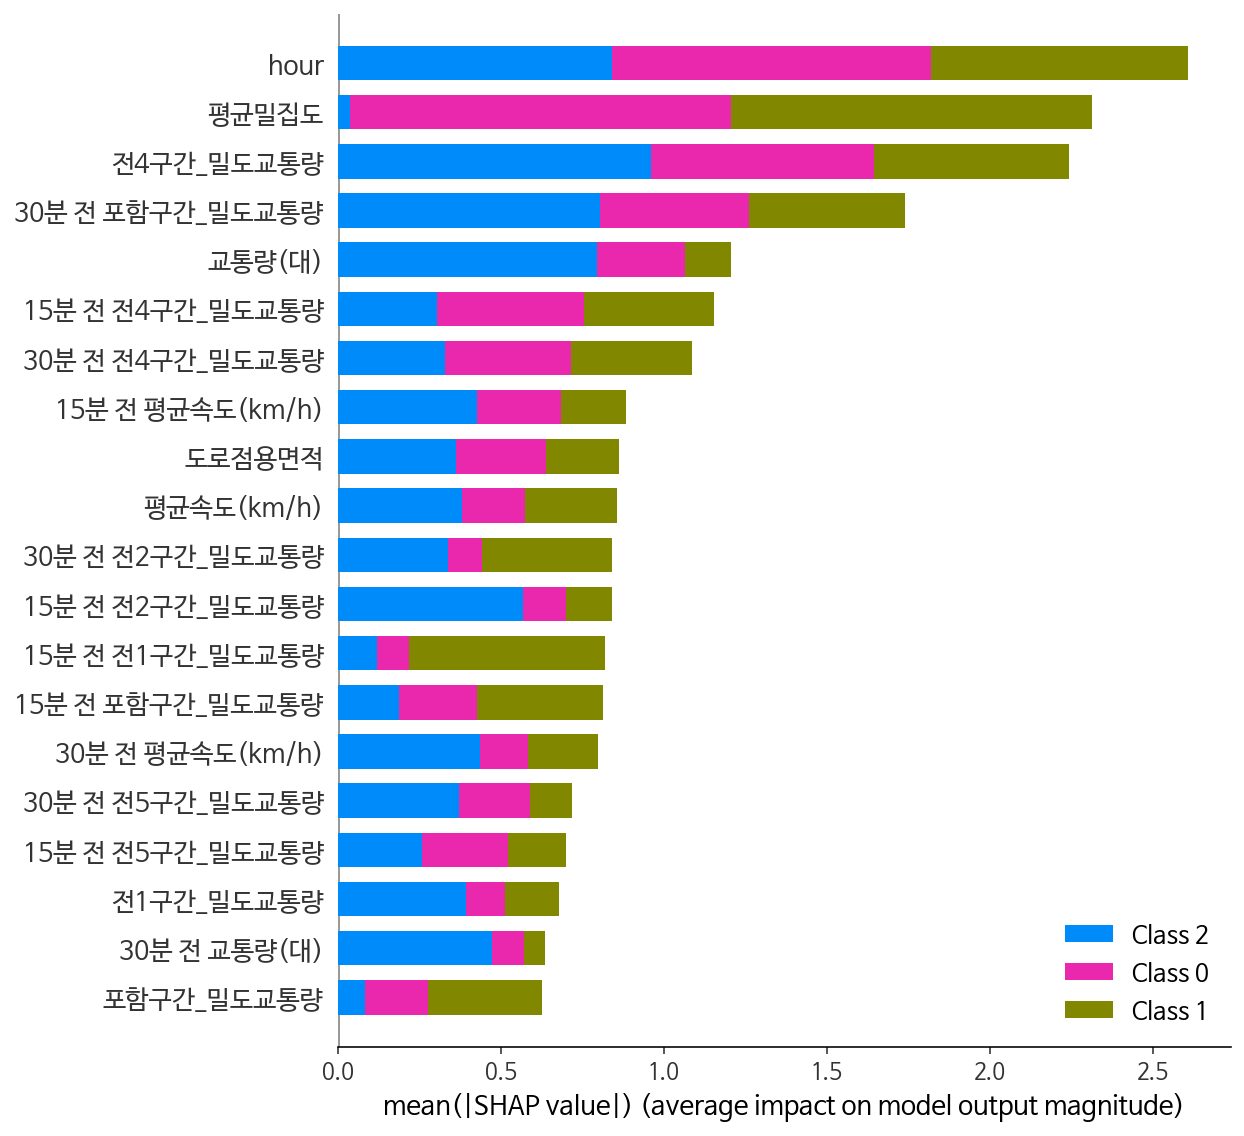

In [ ]:
try:
  import shap
except ImportError:
  !pip install shap
  import shap

shap_values = shap.TreeExplainer(lgb_model_GS.booster_).shap_values(X_test)

shap.summary_plot(shap_values, X_train, plot_type='bar')

LightGBM 알고리즘으로 변수 중요도를 살펴본 결과, 랜덤포레스트의 변수중요도 결과와 마찬가지로 전구간 밀도교통량 변수가 유의미한 것으로 나타났으며, 특히 전4구간이 유의미한 것으로 보인다. 변수에 대한 Class별 변수중요도를 살펴보면 hour은 모든 클래스 분류에서 중요하고 평균밀집도는 Class0과 Class1을 잘 분류했으며 '전4구간_밀도교통량'은 Class2에 대해 잘 분류한 것으로 보인다. 휴게소의 일반적인 특징들 중에서는 '연휴첫째날', 'hour'과 같이 휴게소에 사람이 몰리는 시간과 관련된 변수들과 '도로점용면적' 같이 휴게소의 크기와 관련된 변수들이 중요한 것으로 나타났다.  
한편 교통사고 발생 여부와 전기차 충전소 여부는 휴게소의 위험도를 예측하는 데 기여하지 못하는 것으로 나타났다. 

#### **정리**
15분 후 위험도를 예측하는 세 가지 모델 중에서 XGBoost의 성능이 가장 좋았다.


## __본론3. 드라이브스루 휴게소 위치 제안__  

### __3-1. 졸음쉼터를 활용한 드라이브스루 휴게소 위치 제안__

  <img src='https://drive.google.com/uc?export=view&id=1ixDbIjv8yqIC81wKRGvP0iUEpjXO_P7y' width="800">

___
* 고속도로에는 휴게소 외에도 곳곳에 졸음쉼터가 설치되어 필요한 경우 운전자가 휴식을 취할 수 있다. 본 분석에서는 휴게소의 밀집 위험도가 높을 때 인원을 효과적으로 분산시키기 위한 방법으로 __푸드트럭을 이용한 졸음쉼터에의 드라이브 스루 휴게소 설치__를 제안한다. 
* 드라이브 스루 (Drive Thru)란 자동차에서 내리지 않은 상태로 서비스를 받을 수 있는 운영 방식이다. 본 분석에서 제시하는 __드라이브스루 휴게소는 졸음쉼터내 공간을 활용하여 식음료를 판매하는 푸드트럭 영업장으로 정의__한다. 
* 드라이브스루 휴게소를 통해 운전자는 교통 흐름을 방해하지 않으면서 비대면 방식으로 다양한 식음료를 구매하고 차량 내에서 섭취할 수 있다. 
* 졸음쉼터를 활용한 드라이브스루 휴게소 설치를 통해 휴게소 인원 분산 외에도 기존 페스티벌 등에서 비정기적으로 영업하던 푸드트럭 자영업자들에게 영업기회 제공이라는 사회/경제적 측면에서의 효과 또한 기대할 수 있다. 
 


---

지금까지 구축한 데이터셋을 활용하여 드라이브스루 휴게소의 위치를 제안하고자 한다. 물론 모든 휴게소 전후로 드라이브스루 휴게소가 설치된다면 좋겠지만, 본 분석에서는 드라이브스루 휴게소를 가장 우선적으로 배치해야 할 휴게소를 선정하고자 한다. 드라이브스루 휴게소가 가장 필요한 휴게소를 선정하기 위해 __휴게소 밀집도, 휴게소 평균체류시간, 직전 휴게소로부터의 거리__ 의 세 가지 기준으로 살펴보기로 한다. 


### 기준 1. 휴게소 밀집도
드라이브스루 휴게소가 필요한 휴게소를 찾기 위해 단연 가장 먼저 살펴보아야 할 것은 밀집도일 것이다. 분석 초반에도 언급했다시피 코로나19 확산 위험 측면에서 높은 밀집도는 곧 감염으로 이어지기 때문이다. 

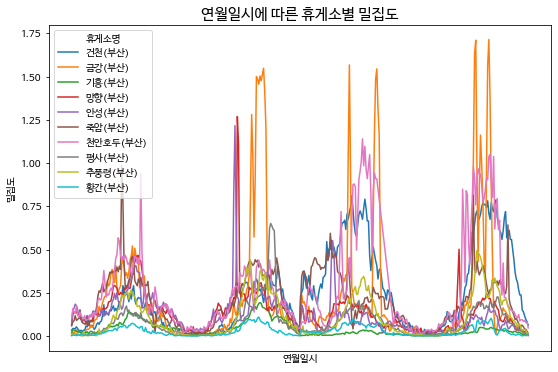

In [ ]:
#휴게소별 연월일시에 따른 밀집도
final['연월일시'] = final['datetime_15'].astype(str)

plt.figure(figsize=(9,6))
plt.xticks(rotation=-45)
df=final.loc[:,['연월일시','휴게소명','밀집도']]
sns.lineplot(data=df, x='연월일시',y='밀집도', hue='휴게소명', ci=None)

plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

plt.title('연월일시에 따른 휴게소별 밀집도', fontdict={'fontsize':15})
plt.show()

분석 대상인 총 4일간의 휴게소별 밀집도를 살펴보면, 금강 휴게소와 천안호두 휴게소가 눈에 띄게 높은 것을 확인할 수 있다.

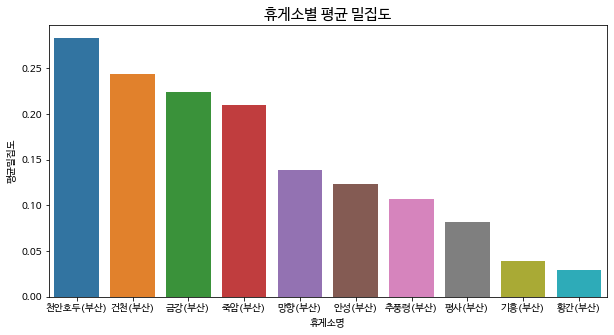

In [ ]:
# 평균밀집도
plt.figure(figsize=(10,5))
df=final.sort_values(by='평균밀집도', ascending=False)
sns.barplot(data=df, x='휴게소명',y='평균밀집도')
plt.title('휴게소별 평균 밀집도', fontdict={'fontsize':15})
plt.show()

평균 밀집도의 경우에는 천안호두, 건천, 금강, 죽암 순으로 높은 밀집도를 갖는 것을 볼 수 있다.

### 기준 2. 휴게소 평균체류시간

* 체류시간이 높은 휴게소의 경우, 체류시간이 낮은 휴게소보다 내부 음식점 이용률이 높을 것이라고 유추할 수 있다. 코로나 확산위험을 고려한다면 평균 체류시간이 높은 휴게소에 더욱 주의를 기울여야 한다고 판단 할 수 있다.

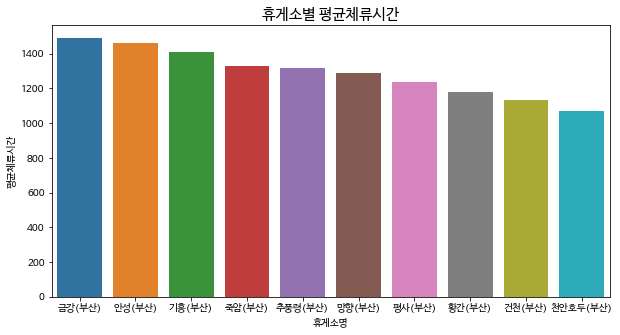

In [ ]:
#평균체류시간
plt.figure(figsize=(10,5))
df=final.sort_values(by='평균체류시간', ascending=False)
sns.barplot(data=df, x='휴게소명',y='평균체류시간')
plt.title('휴게소별 평균체류시간', fontdict={'fontsize':15})
plt.show()

* 휴게소별 평균 체류시간을 살펴보면 천안호두 휴게소의 경우 평균 밀집도는 가장 높으나 평균 체류시간은 가장 낮고, 금강 휴게소의 경우 평균 밀집도는 3위이나 평균 체류시간은 가장 높은 것으로 나타난다. 
* 기준 1에서 평균 밀집도가 높았던 천안호두, 건천, 금강, 죽암 휴게소 중 평균 체류시간도 높은 휴게소는 금강과 죽암 휴게소로 볼 수 있다.

### 기준 3. 직전 휴게소로부터의 거리
드라이브스루 휴게소의 위치를 선정하기 위한 마지막 기준으로 직전 휴게소로부터의 거리를 고려한다.

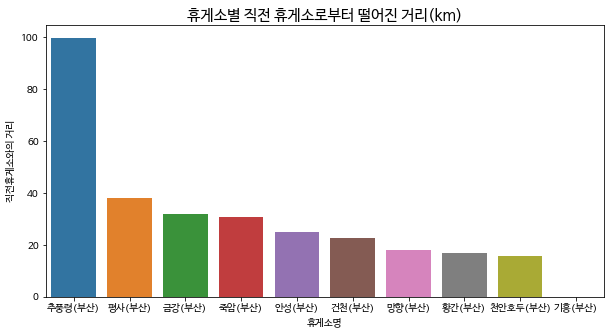

In [ ]:
# 직전휴게소로부터의 거리
plt.figure(figsize=(10,5))
df=final.sort_values(by='직전휴게소와의 거리', ascending=False)
sns.barplot(data=df, x='휴게소명',y='직전휴게소와의 거리') 
plt.title('휴게소별 직전 휴게소로부터 떨어진 거리(km)', fontdict={'fontsize':15})
plt.show()

* 시각화 결과, 직전 휴게소로부터 떨어진 거리가 먼 휴게소들을 살펴보면 추풍령, 평사, 금강, 죽암 휴게소 등이 있다. 이 중 금강과 죽암 휴게소는 앞서 기준 1, 기준 2에서도 언급되었다. 
* __따라서 세 가지 기준에 의해 금강과 죽암 휴게소에 대해 드라이브스루 휴게소 설치를 우선적으로 고려할 수 있다.__

--- 

이번에는 밀집도가 높은 순으로 상위 20개의 데이터를 뽑아보았다.

In [ ]:
final[['휴게소명','datetime_15','연휴첫째날','hour','밀집도','위험도']].sort_values(by='밀집도', ascending=False)[:20]

,휴게소명,datetime_15,연휴첫째날,hour,밀집도,위험도
734,금강(부산),2020-01-25 15:30:00,0,15,1.714941,3
723,금강(부산),2020-01-25 12:45:00,0,12,1.710962,3
722,금강(부산),2020-01-25 12:30:00,0,12,1.631383,3
617,금강(부산),2020-01-24 10:15:00,1,10,1.567719,3
733,금강(부산),2020-01-25 15:15:00,0,15,1.563740,3
545,금강(부산),2019-02-05 16:15:00,0,16,1.548819,3
640,금강(부산),2020-01-24 16:00:00,1,16,1.544840,3
544,금강(부산),2019-02-05 16:00:00,0,16,1.512013,3
542,금강(부산),2019-02-05 15:30:00,0,15,1.504055,3
539,금강(부산),2019-02-05 14:45:00,0,14,1.500076,3


밀집도 상위 20개를 뽑아보면 다음과 같이 대부분 금강 휴게소임을 알 수 있다.  
평균적인 밀집도는 천안호두, 건천 등의 휴게소에서 가장 높게 나타나는데 어째서 금강 휴게소가 상위 20개를 점령한 것일까?

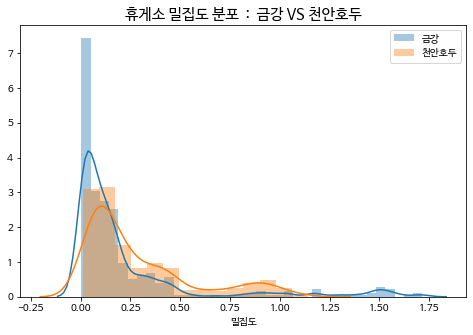

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(final.loc[final['휴게소명']=='금강(부산)','밀집도'], label='금강')
sns.distplot(final.loc[final['휴게소명']=='천안호두(부산)','밀집도'], label='천안호두')
plt.legend()
plt.title('휴게소 밀집도 분포  :  금강 VS 천안호두', fontdict={'fontsize':15})
plt.show()

평균 밀집도 1위인 천안호두 휴게소와 비교해보면 금강휴게소는 밀집도가 낮은 값에 몰려있지만, 밀집도가 1.5 이상의 극단적으로 큰 값도 나타나기 때문에 밀집도 상위 20개가 대부분 금강휴게소로 나타났다고 해석할 수 있다. 

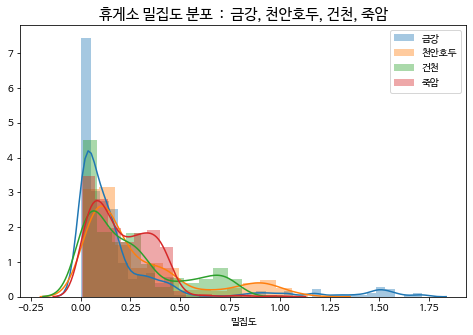

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(final.loc[final['휴게소명']=='금강(부산)','밀집도'], label='금강')
sns.distplot(final.loc[final['휴게소명']=='천안호두(부산)','밀집도'], label='천안호두')
sns.distplot(final.loc[final['휴게소명']=='건천(부산)','밀집도'], label='건천')
sns.distplot(final.loc[final['휴게소명']=='죽암(부산)','밀집도'], label='죽암')
plt.legend()
plt.title('휴게소 밀집도 분포  :  금강, 천안호두, 건천, 죽암', fontdict={'fontsize':15})
plt.show()

* 밀집도가 높은 편에 속하는 천안호두, 건천, 죽암 휴게소와 비교해보았을 때 금강 휴게소의 분포는 낮은 밀집도에 매우 몰려있으면서도 극단적으로 높은 값 또한 갖는 독특한 형태임을 확인할 수 있다. 즉 금강 휴게소는 왼쪽으로 치우쳐있으면서도 오른쪽 꼬리가 매우 긴 분포를 갖는다.
* 평균적인 밀집도는 1위가 아니지만, 다른 휴게소들과 달리 극단적으로 높은 밀집도를 갖는 __금강 휴게소__를 인원 분산 측면에서 중요하게 보는 것이 본 분석의 취지에 맞을 것이다. 

### 결론
* 휴게소 밀집도, 휴게소 평균체류시간, 직전 휴게소로부터의 거리라는 세가지 기준에 의해 10개의 휴게소를 검토한 결과, 금강 휴게소와 죽암 휴게소근처가 드라이브스루 휴게소를 설치하기에 적절한 휴게소로 드러났다.
* 휴게소별 밀집도의 분포를 살펴본 결과, 금강 휴게소는 다른 밀집도 상위권 휴게소들에 비해 독특한 형태를 가지는 것을 확인할 수 있었다. 비록 낮은 밀집도에 몰려있긴 하지만, 다른 어느 휴게소도 갖지 않는 극단적으로 높은 밀집도를 가지므로 드라이브스루 휴게소의 필요성이 매우 크다고 판단하였다. 
* 따라서, __금강 휴게소__ 근처에 드라이브스루 휴게소를 우선적으로 배치해야한다고 결론짓는다.

---
드라이브 스루 휴게소를 설치하기 위한 졸음 쉼터를 지도에 시각화해보기로 한다.

In [3]:
#졸음쉼터 데이터 불러오기
sleepy_info = pd.read_excel('./졸음쉼터 및 휴게소 관련 데이터/고속도로 졸음쉼터 설치현황(2019년).xlsx')
sleepy_info = sleepy_info[sleepy_info['도로노선명'] == '경부선']

In [4]:
# 경부선 휴게소 & 졸음쉼터 지도에 표시
m_hugeso_sleepy = folium.Map(location=[36,127], tiles='cartodbpositron', zoom_start=8)

for i in range(0,len(hugeso_info_down)):
    if hugeso_info_down.loc[i,'휴게소명']=='금강(부산)':
        Circle(
            location=[hugeso_info_down.iloc[i]['위도'], hugeso_info_down.iloc[i]['경도']],
            radius=1000,
            color='red', fill='red',
            popup=hugeso_info_down.iloc[i]['휴게소명']).add_to(m_hugeso_sleepy) 
    else: Circle(
            location=[hugeso_info_down.iloc[i]['위도'], hugeso_info_down.iloc[i]['경도']],
            radius=1000,
            color='gray', fill='gray',
            popup=hugeso_info_down.iloc[i]['휴게소명']).add_to(m_hugeso_sleepy)

for i in range(0,len(sleepy_info)):
    Marker(
        location=[sleepy_info.iloc[i]['위도'], sleepy_info.iloc[i]['경도']],
        popup=sleepy_info.iloc[i]['졸음쉼터명']).add_to(m_hugeso_sleepy) 

m_hugeso_sleepy

* 지도에서 붉은색 원은 금강 휴게소의 위치, 회색 원은 금강 휴게소 외 휴게소의 위치를 나타낸다.
* 파란색 마커는 졸음쉼터의 위치를 나타낸다.
---
* 금강 휴게소의 직전 휴게소는 죽암 휴게소이다. 위경도 자료를 활용하여 계산한 두 휴게소 사이의 거리는 약 31.7km로, 두 휴게소간 간격이 상당히 넓다는 것을 지도 상으로도 확인할 수 있다. 
* 따라서, 앞서 결론지은바에 따라 죽암 휴게소와 금강휴게소 사이에 있는 __옥천 졸음쉼터에 드라이브스루 휴게소 설치를 제안__한다.  
* 특히 **집중 밀집 시간대인 10시부터 16시 경**에 드라이브스루 휴게소를 적극 활용할 수 있도록 유도한다면 금강휴게소로의 밀집도를 낮춰 코로나19의 위험으로부터 보다 안전한 이동을 기대할 수 있을 것이다.  
<img src='https://drive.google.com/uc?export=view&id=1UW0gXR0rEgOqwJtLjPZ1xGW5EpnxHM6Y' width="800">


### __3-2. 휴게소 밀집도 예측 시스템을 활용한 드라이브스루 휴게소 활성화 방안__
---
* 본 분석에서 제시한 휴게소 밀집도 예측모델을 활용하여 보다 효과적으로 휴게소의 인원을 분산시키고 드라이브스루 휴게소를 활성화시키는 시스템을 제안하고자 한다.  
* 다음과 같이 실시간 휴게소 밀집도 예측 시스템을 구축하여 운전자는 네비게이션 등에서 주행 중에 휴게소의 예상 위험도에 대한 알림을 받을 수 있다.
 * 예시) "전방 20km 금강 휴게소의 15분 후 예상 밀집 위험도 3단계입니다. 코로나19 예방과 생활 속 거리두기를 위해 전방 10km 내 위치한 옥천 드라이브스루 휴게소 이용을 추천합니다."

* 이처럼 사전에 휴게소 위험도를 안내받은 운전자는 휴게소에 도달하기 전 드라이브스루 휴게소에서 식음료를 섭취하고 휴식을 취할 수 있다. 
* 명절 연휴와 같이 교통량이 많은 상황에서는 드라이브스루 휴게소의 회전율을 높이기 위하여 모바일 앱을 통한 판매 메뉴 정보 제공, 스타벅스의 사이렌오더와 같은 사전 주문 시스템을 구축한다면 드라이브스루 휴게소를 더욱 편리하게 이용할 수 있을 것으로 기대한다. 

<img src='https://drive.google.com/uc?export=view&id=1qfaI-qUh3yGC3h6kZ0NKJ2fkipoZM1if' width="800">

<img src='https://drive.google.com/uc?export=view&id=1tVvw1o4C6JwoL3_wI8umA0wkzaWNq9Ti' width="800">

<img src='https://drive.google.com/uc?export=view&id=1CMRSFdEjuXNtA602hIBi2LKkRZE-HVdO' width="800">

<img src='https://drive.google.com/uc?export=view&id=1ul3OwV3i_czn4TkjbrTBMebSsMQFNkiR' width="800">

<img src='https://drive.google.com/uc?export=view&id=1Yup21m5hZIMS02bdzIWj7bvtHnibvwKA' width="800">

<img src='https://drive.google.com/uc?export=view&id=1d6zjAZMJEccRTagp4SgqVvSTkAA9gWPW' width="800">

<img src='https://drive.google.com/uc?export=view&id=1Uq2eKR2hPxxmJqNh4OZufClj-rnSL7qY' width="800">

## __결론 및 한계점__
---
### __결론__
* DSRC 데이터와 휴게소 정보 데이터를 활용하여 15분 간격으로 개별 휴게소의 밀집도 및 코로나 확산 위험도를 예측하는 모델을 구축하였다. SVM, XGBClassifier 등의 모델을 통해 약 93% 정도의 예측 정확도를 얻을 수 있었다. 
* 계산된 밀집도와 위험도를 바탕으로 드라이브스루 휴게소의 위치를 선정하였다. 평균 밀집도, 평균 체류시간 등을 고려하여 최종적으로 금강 휴게소 전후의 졸음쉼터를 활용하여 드라이브스루 휴게소 설치를 제안하였다. 
---
### __한계점__
* 휴게소를 이용하는 주된 이유 중 하나는 화장실 이용이다. 졸음쉼터에는 화장실이 있는 경우도 있고 없는 경우도 있기 때문에, 쾌적한 화장실 사용을 원하는 경우에 드라이브스루 휴게소를 이용하지 않는 경우도 많을 수 있다. 그러나 본 분석의 취지는 휴게소 내 코로나 확산 방지이므로 화장실 이용 인원보다는 식당에서 마스크를 쓰지 않고 식사를 하는 인원에 대한 분산이 훨씬 중요하다. 따라서, 화장실 사용을 원하는 경우 기존 휴게소를 이용하되, 식음료 섭취는 드라이브스루 휴게소를 이용한다면 휴게소 코로나 확산 위험은 현저히 줄어들 것이다.  

* DSRC 데이터는 일 단위로 생성되는 데이터이기 때문에 차량을 식별하는 변수인 '가상 OBU_ID'가 매일 초기화된다. 따라서 일자가 바뀌는 시간대, 즉 전일 23시 45분에서 다음날 00시 00분으로 넘어가는 시간대에 대한 밀도교통량을 정확하게 계산할 수 없었다는 한계점이 있다. 그러나 해당 시간대에 고속도로를 이용하는 차량들은 연휴 기간 휴게소를 이용할 때 코로나 확산을 최소화하고자 하는 본 분석의 목표와는 거리가 있는 데이터라고 판단하였다. 



읽어주셔서 감사합니다!

본 저작물의 저작권은 Apache License v2.0을 따릅니다